In [80]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.arima.model import ARIMA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
df = pd.read_csv('../airline_passengers.csv', index_col='Month', parse_dates=True)

In [82]:
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


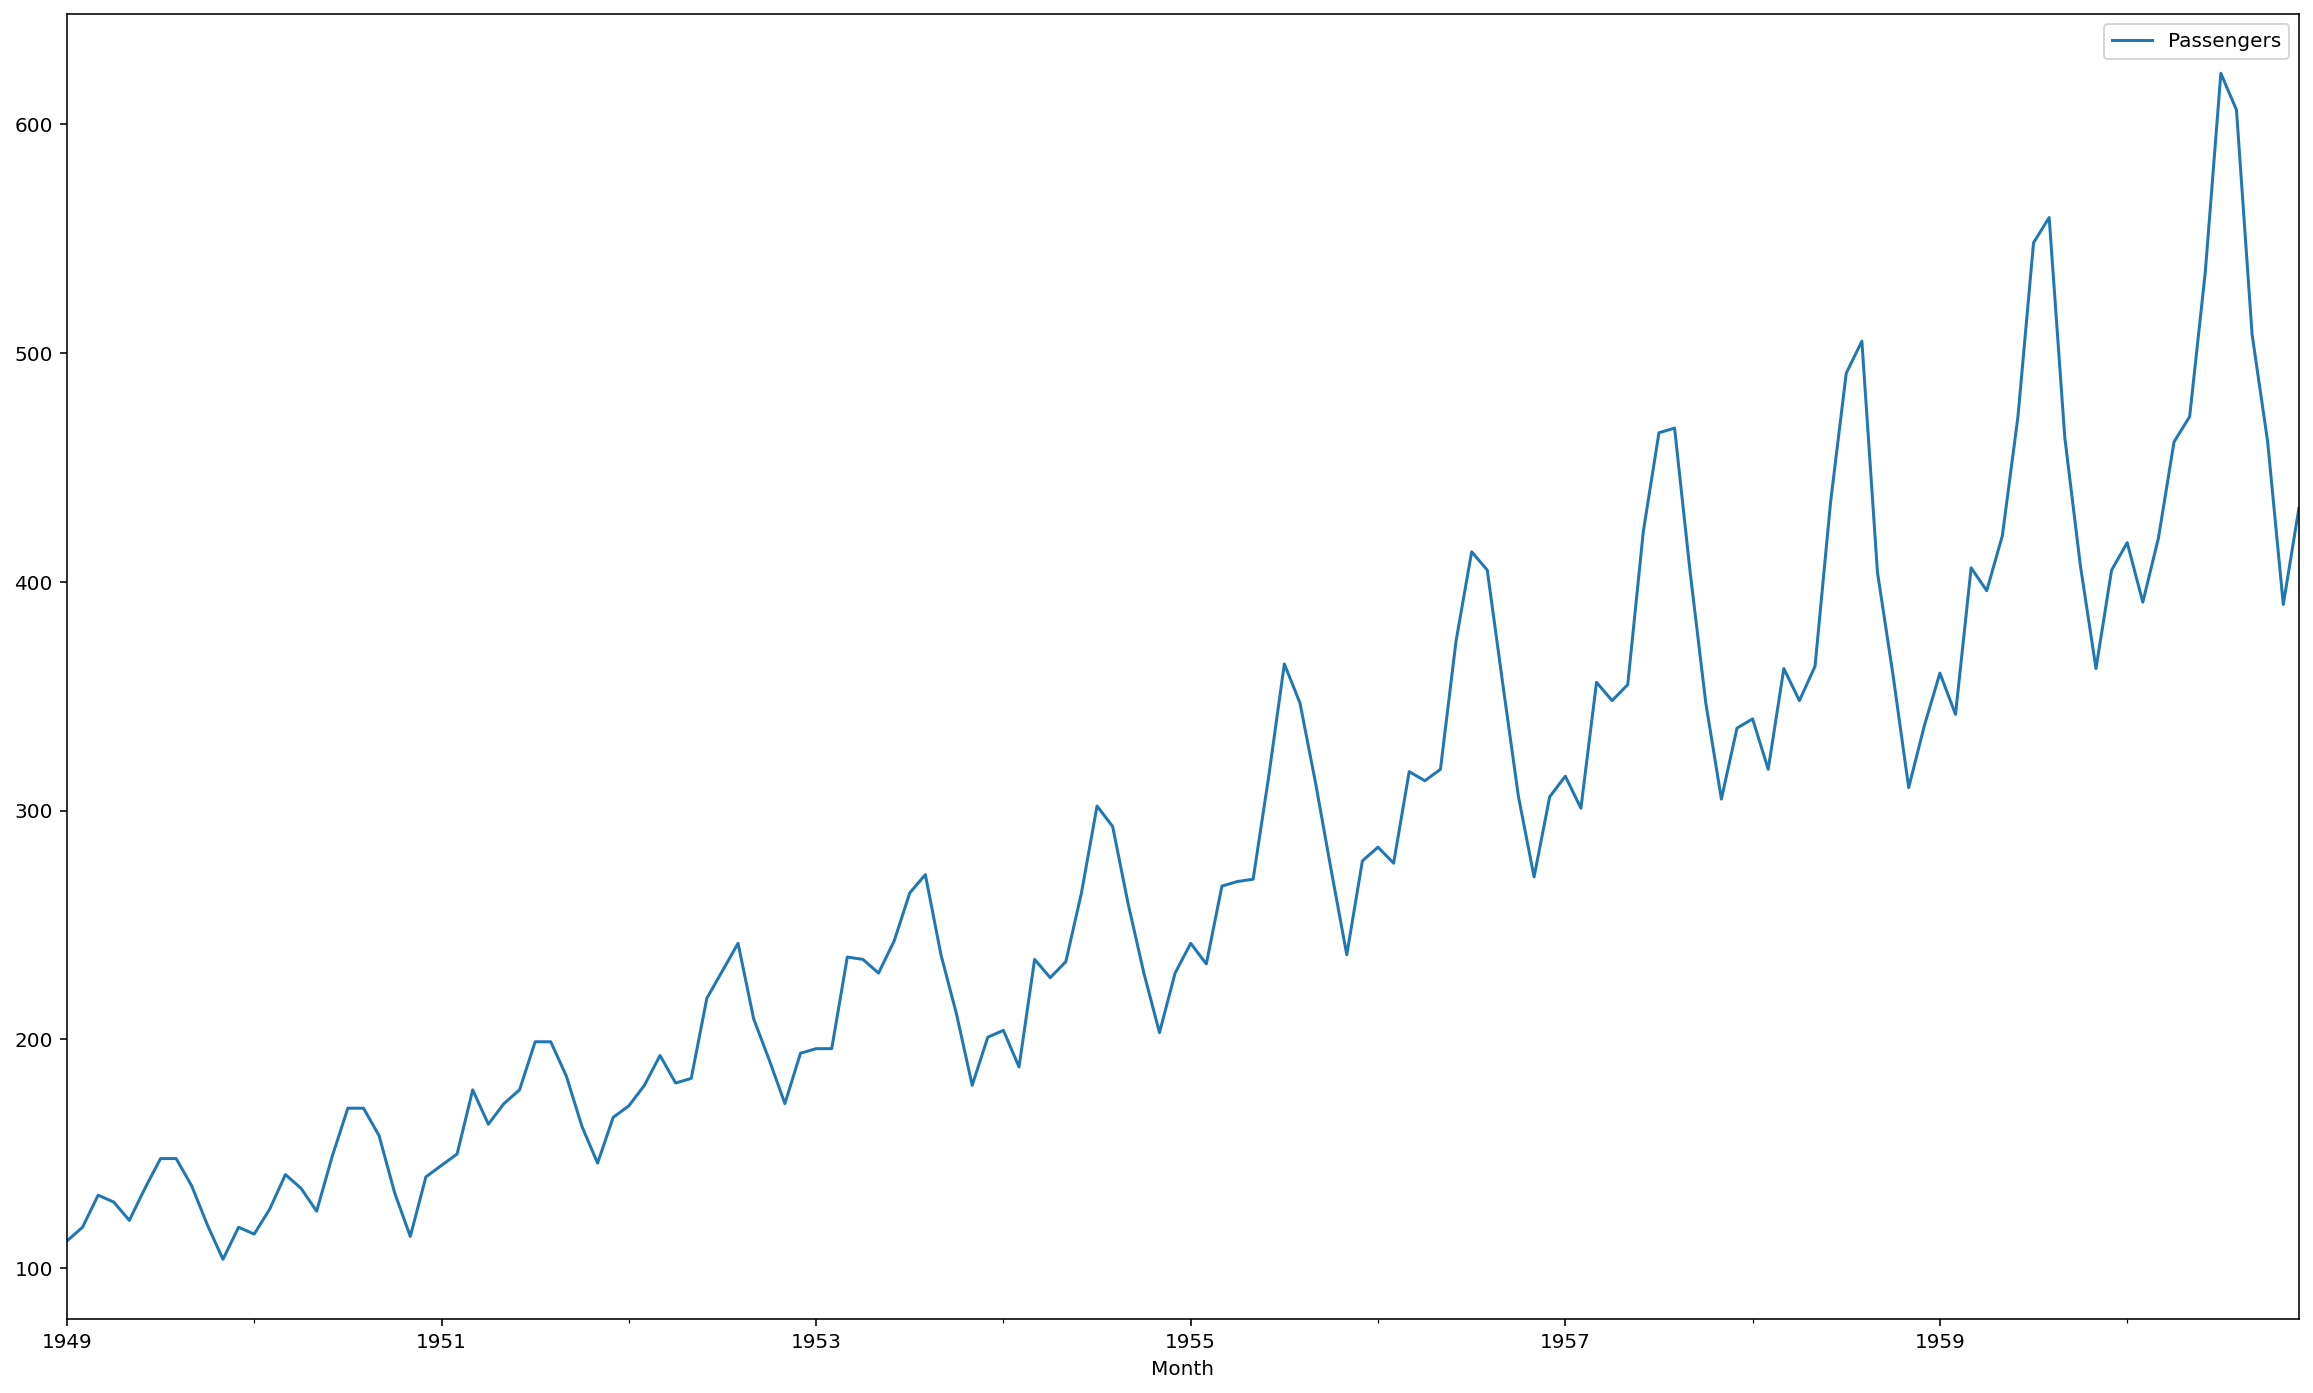

In [83]:
df.plot(figsize=(20, 12));

### First Difference

In [84]:
df['First_Diff'] = df['Passengers'].diff()

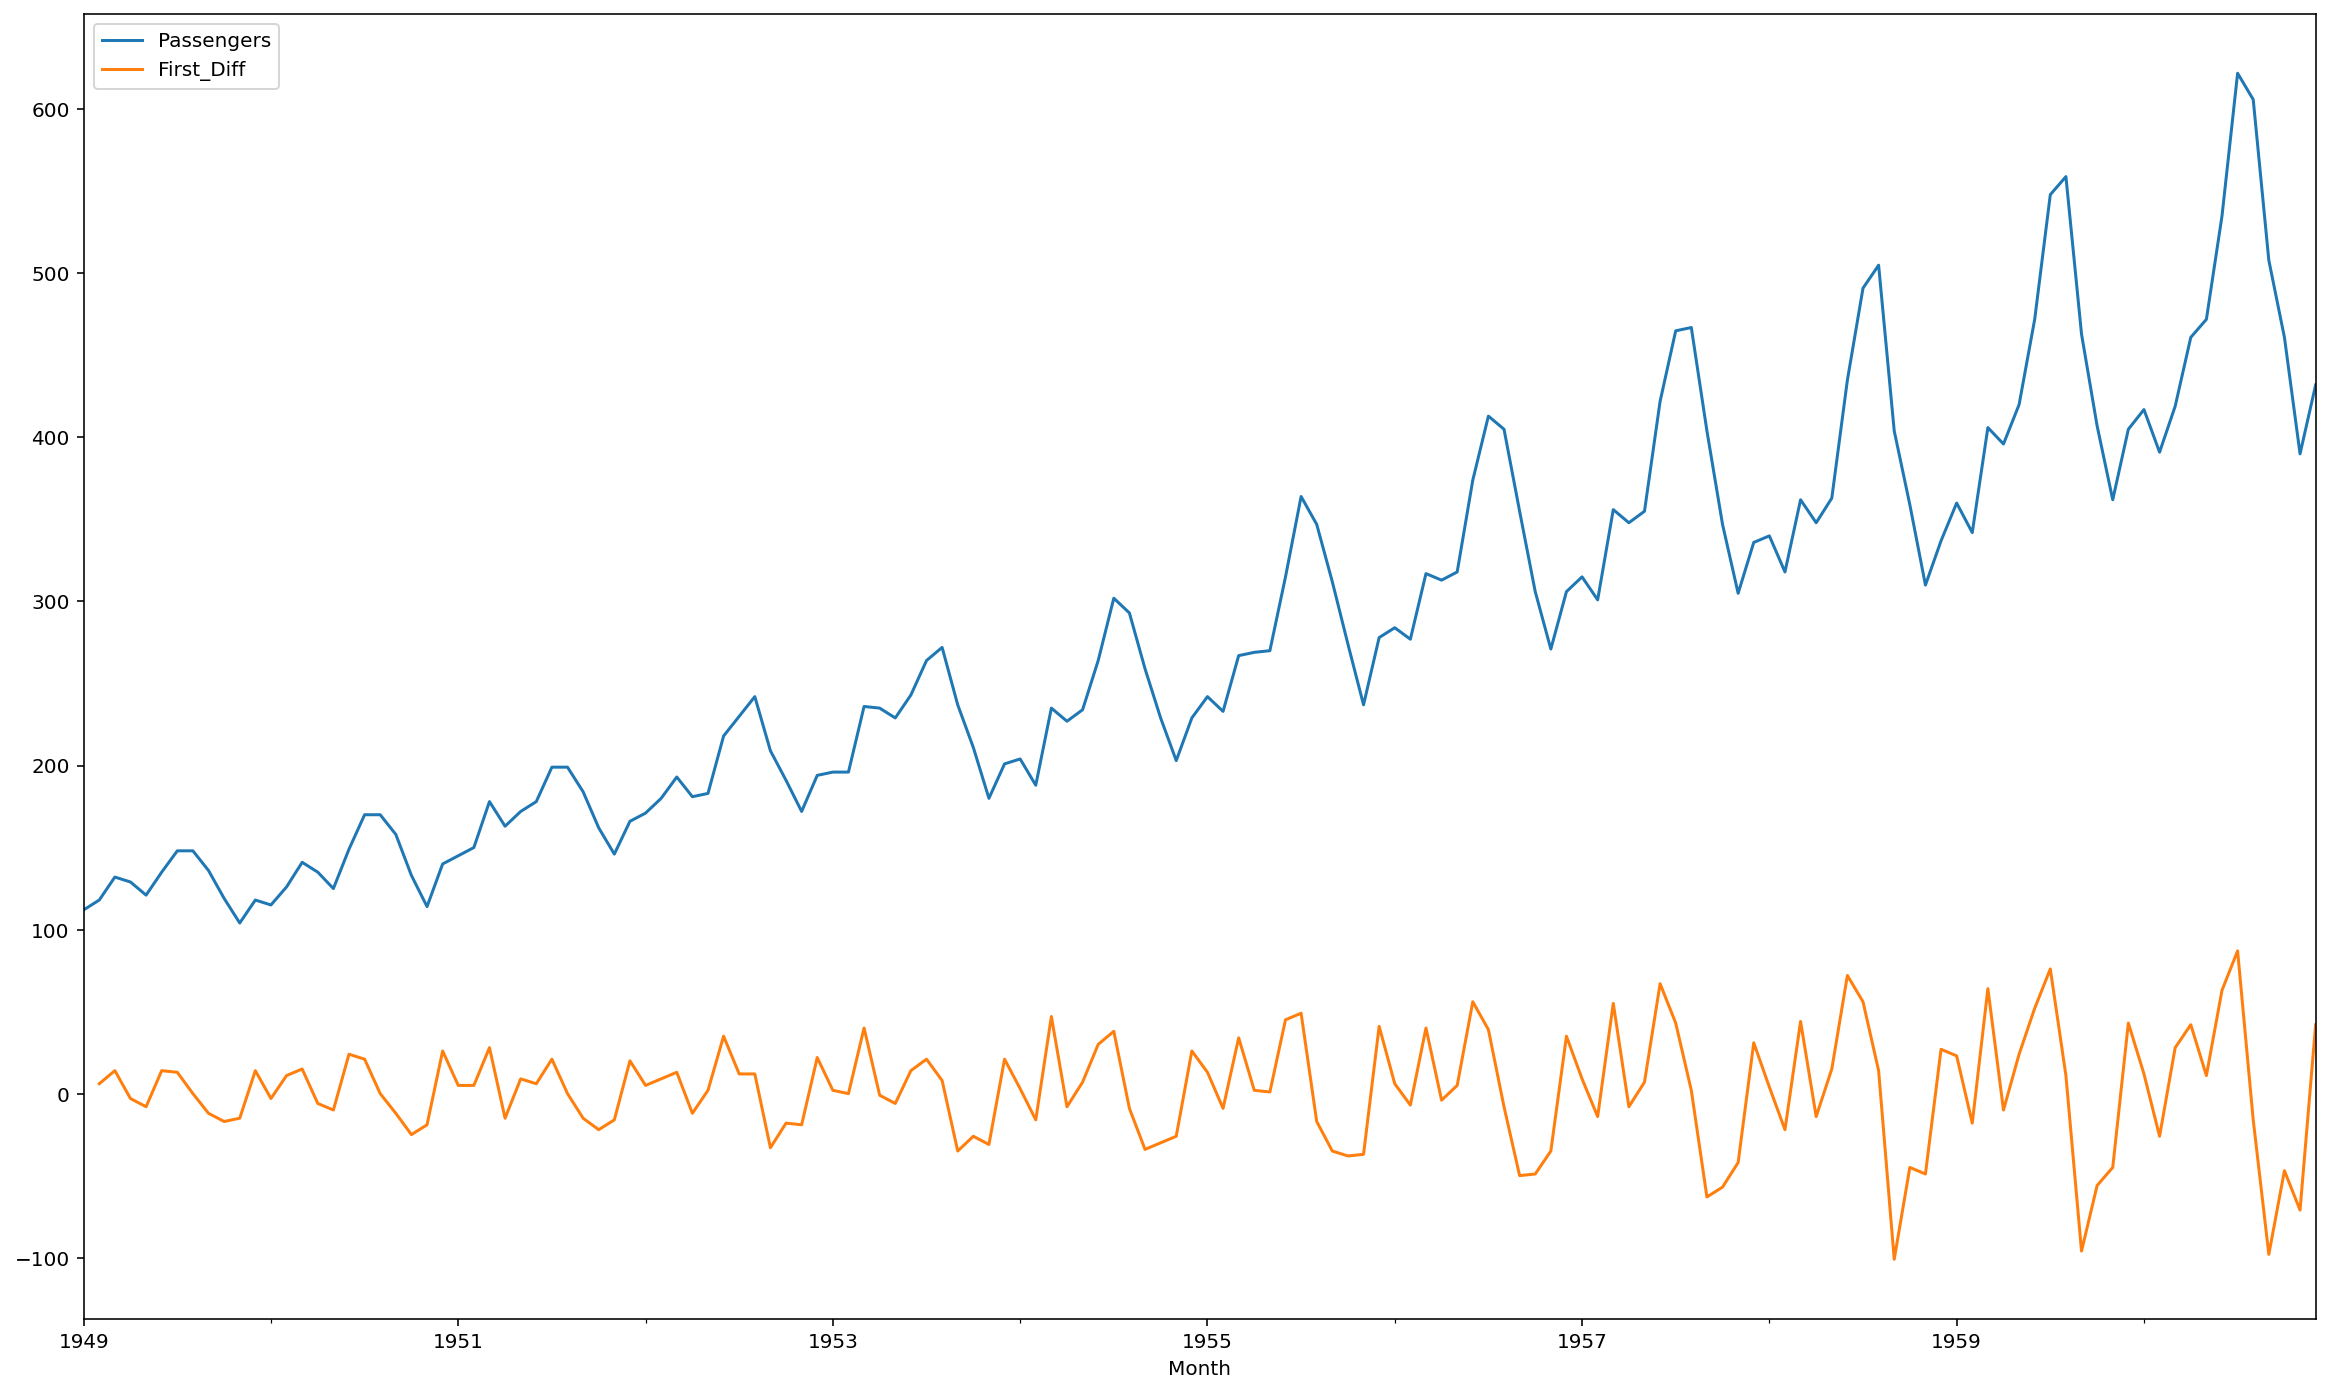

In [85]:
df.plot(figsize=(20, 12));

### Log Price

In [86]:
df['Log_Passengers'] = np.log(df['Passengers'])

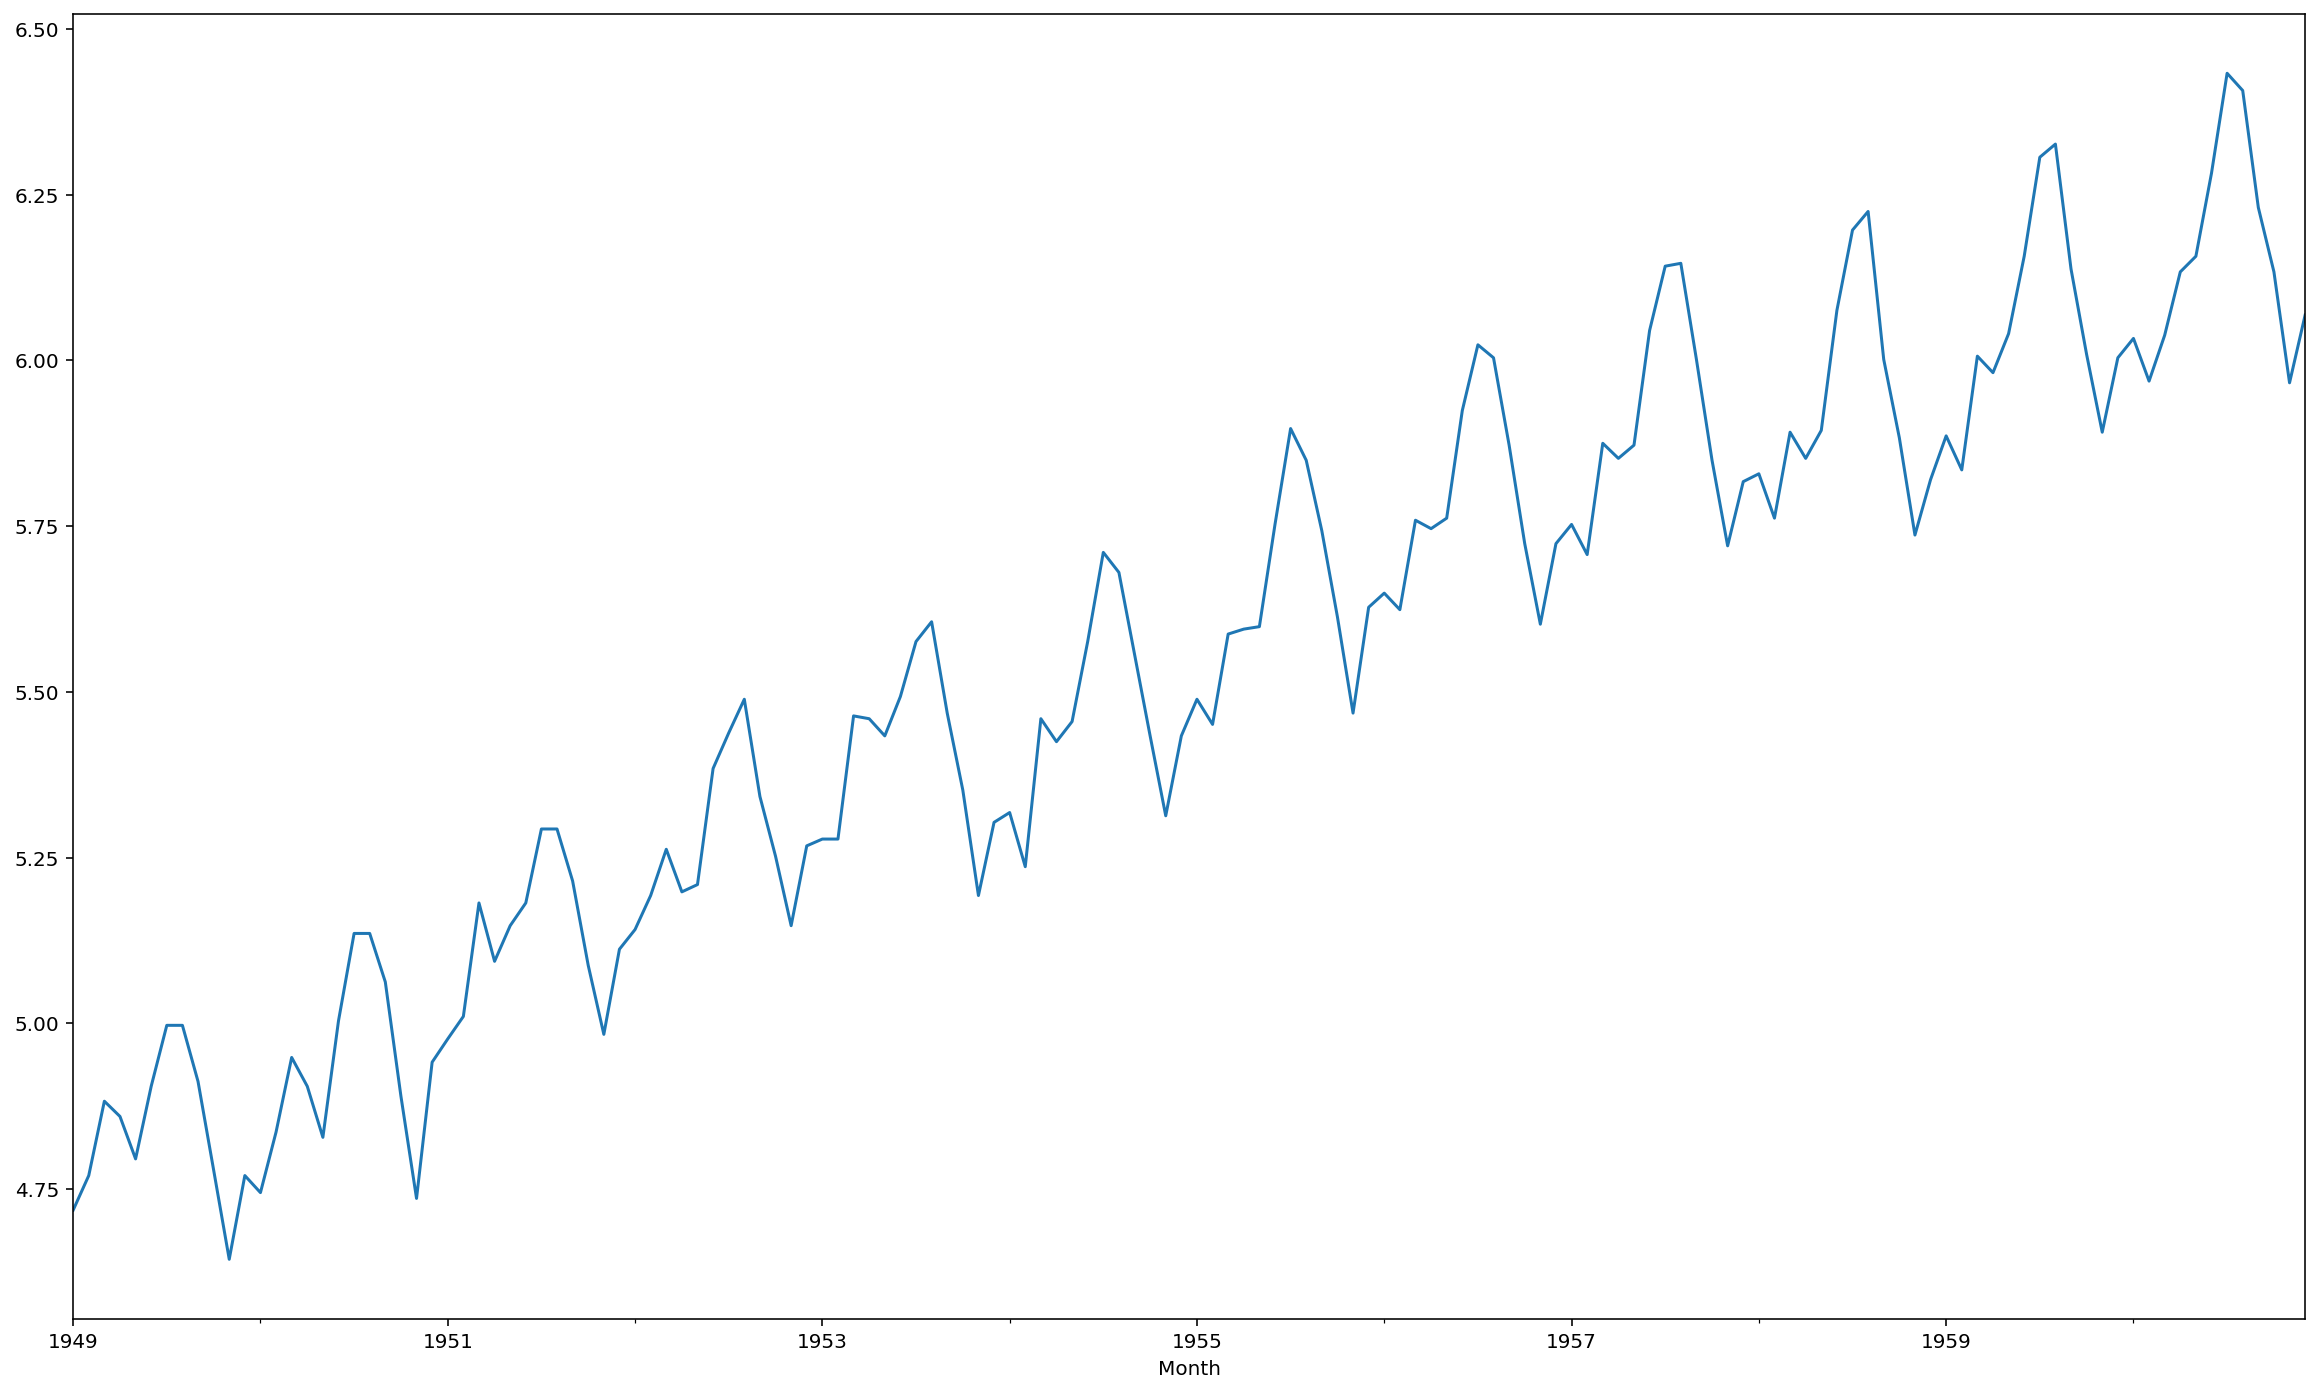

In [87]:
df['Log_Passengers'].plot(figsize=(20, 12));

На лог-цене тренд становится линейным

### ARIMA

In [88]:
df.index.freq = 'MS'

In [89]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [90]:
# Маски по индексам
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [91]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [92]:
arima_result = arima.fit()

In [93]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])
# либо вот так на ттренинговой выборке можно получать результаты
# df.loc[train_idx, 'AR(1)'] = arima_result.fittedvalues

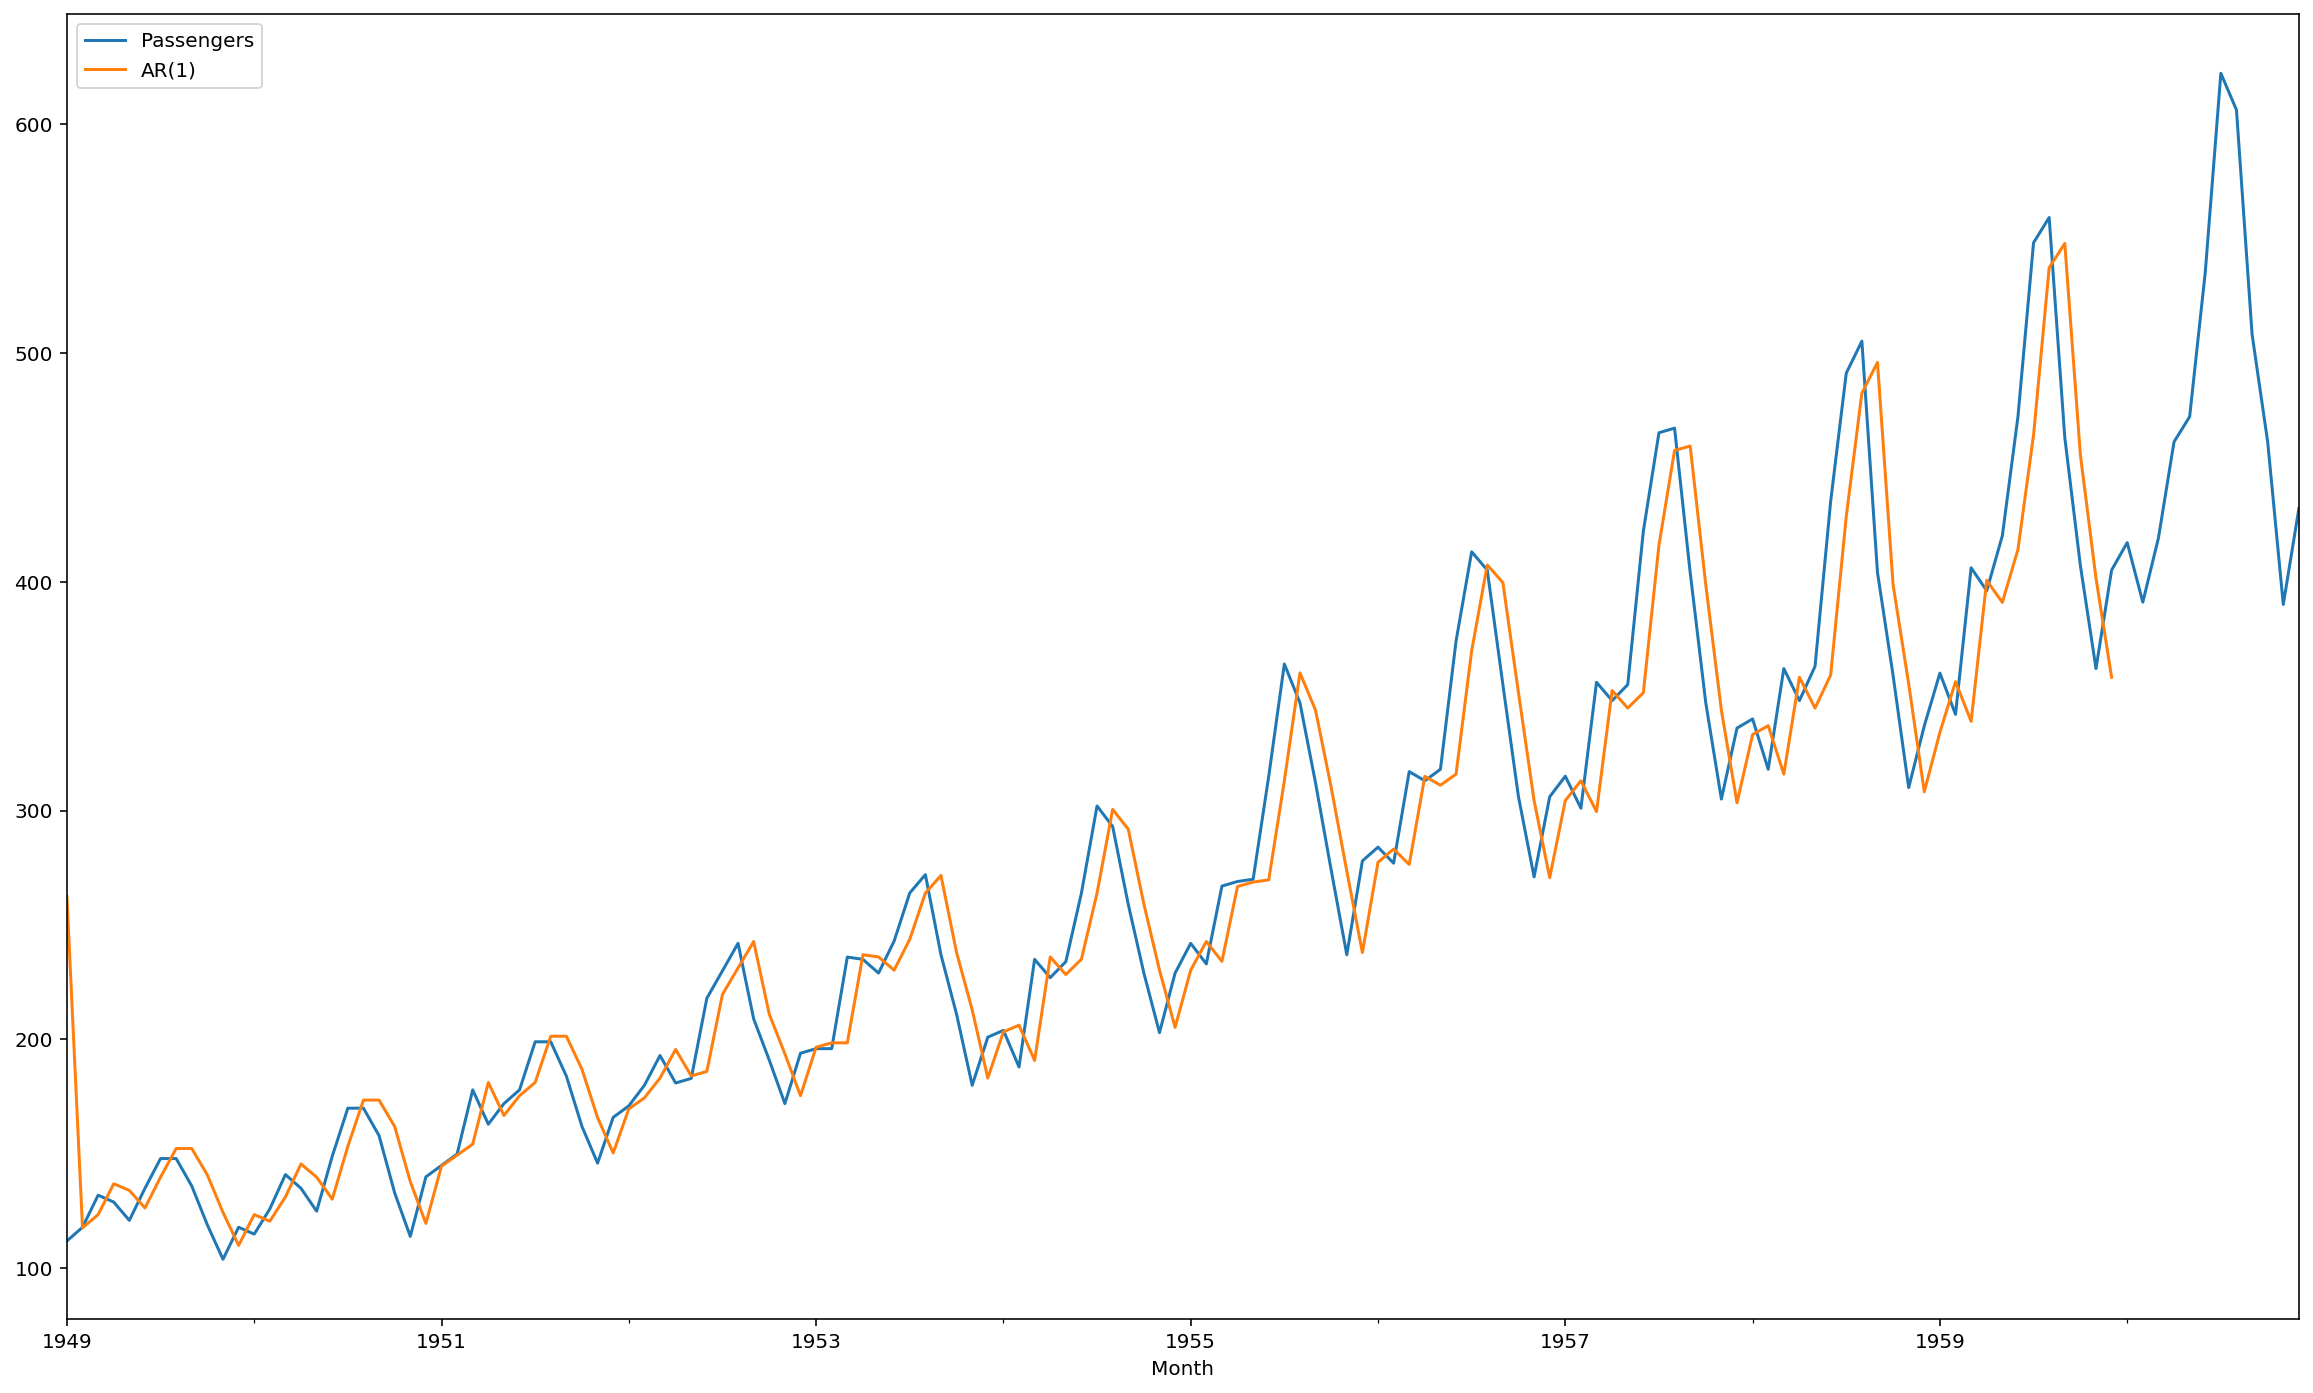

In [94]:
df[['Passengers', 'AR(1)']].plot(figsize=(20,12));

Фактически имеем разновидность наивного прогноза, запаздывание в 1 шаг

###  Прогноз с указанного элемента

In [95]:
prediction_result = arima_result.get_forecast(N_test)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

# либо вот так на будущий период можно получить прогноз
# arima_result.predict(start=test.index[0], end=test.index[-1])

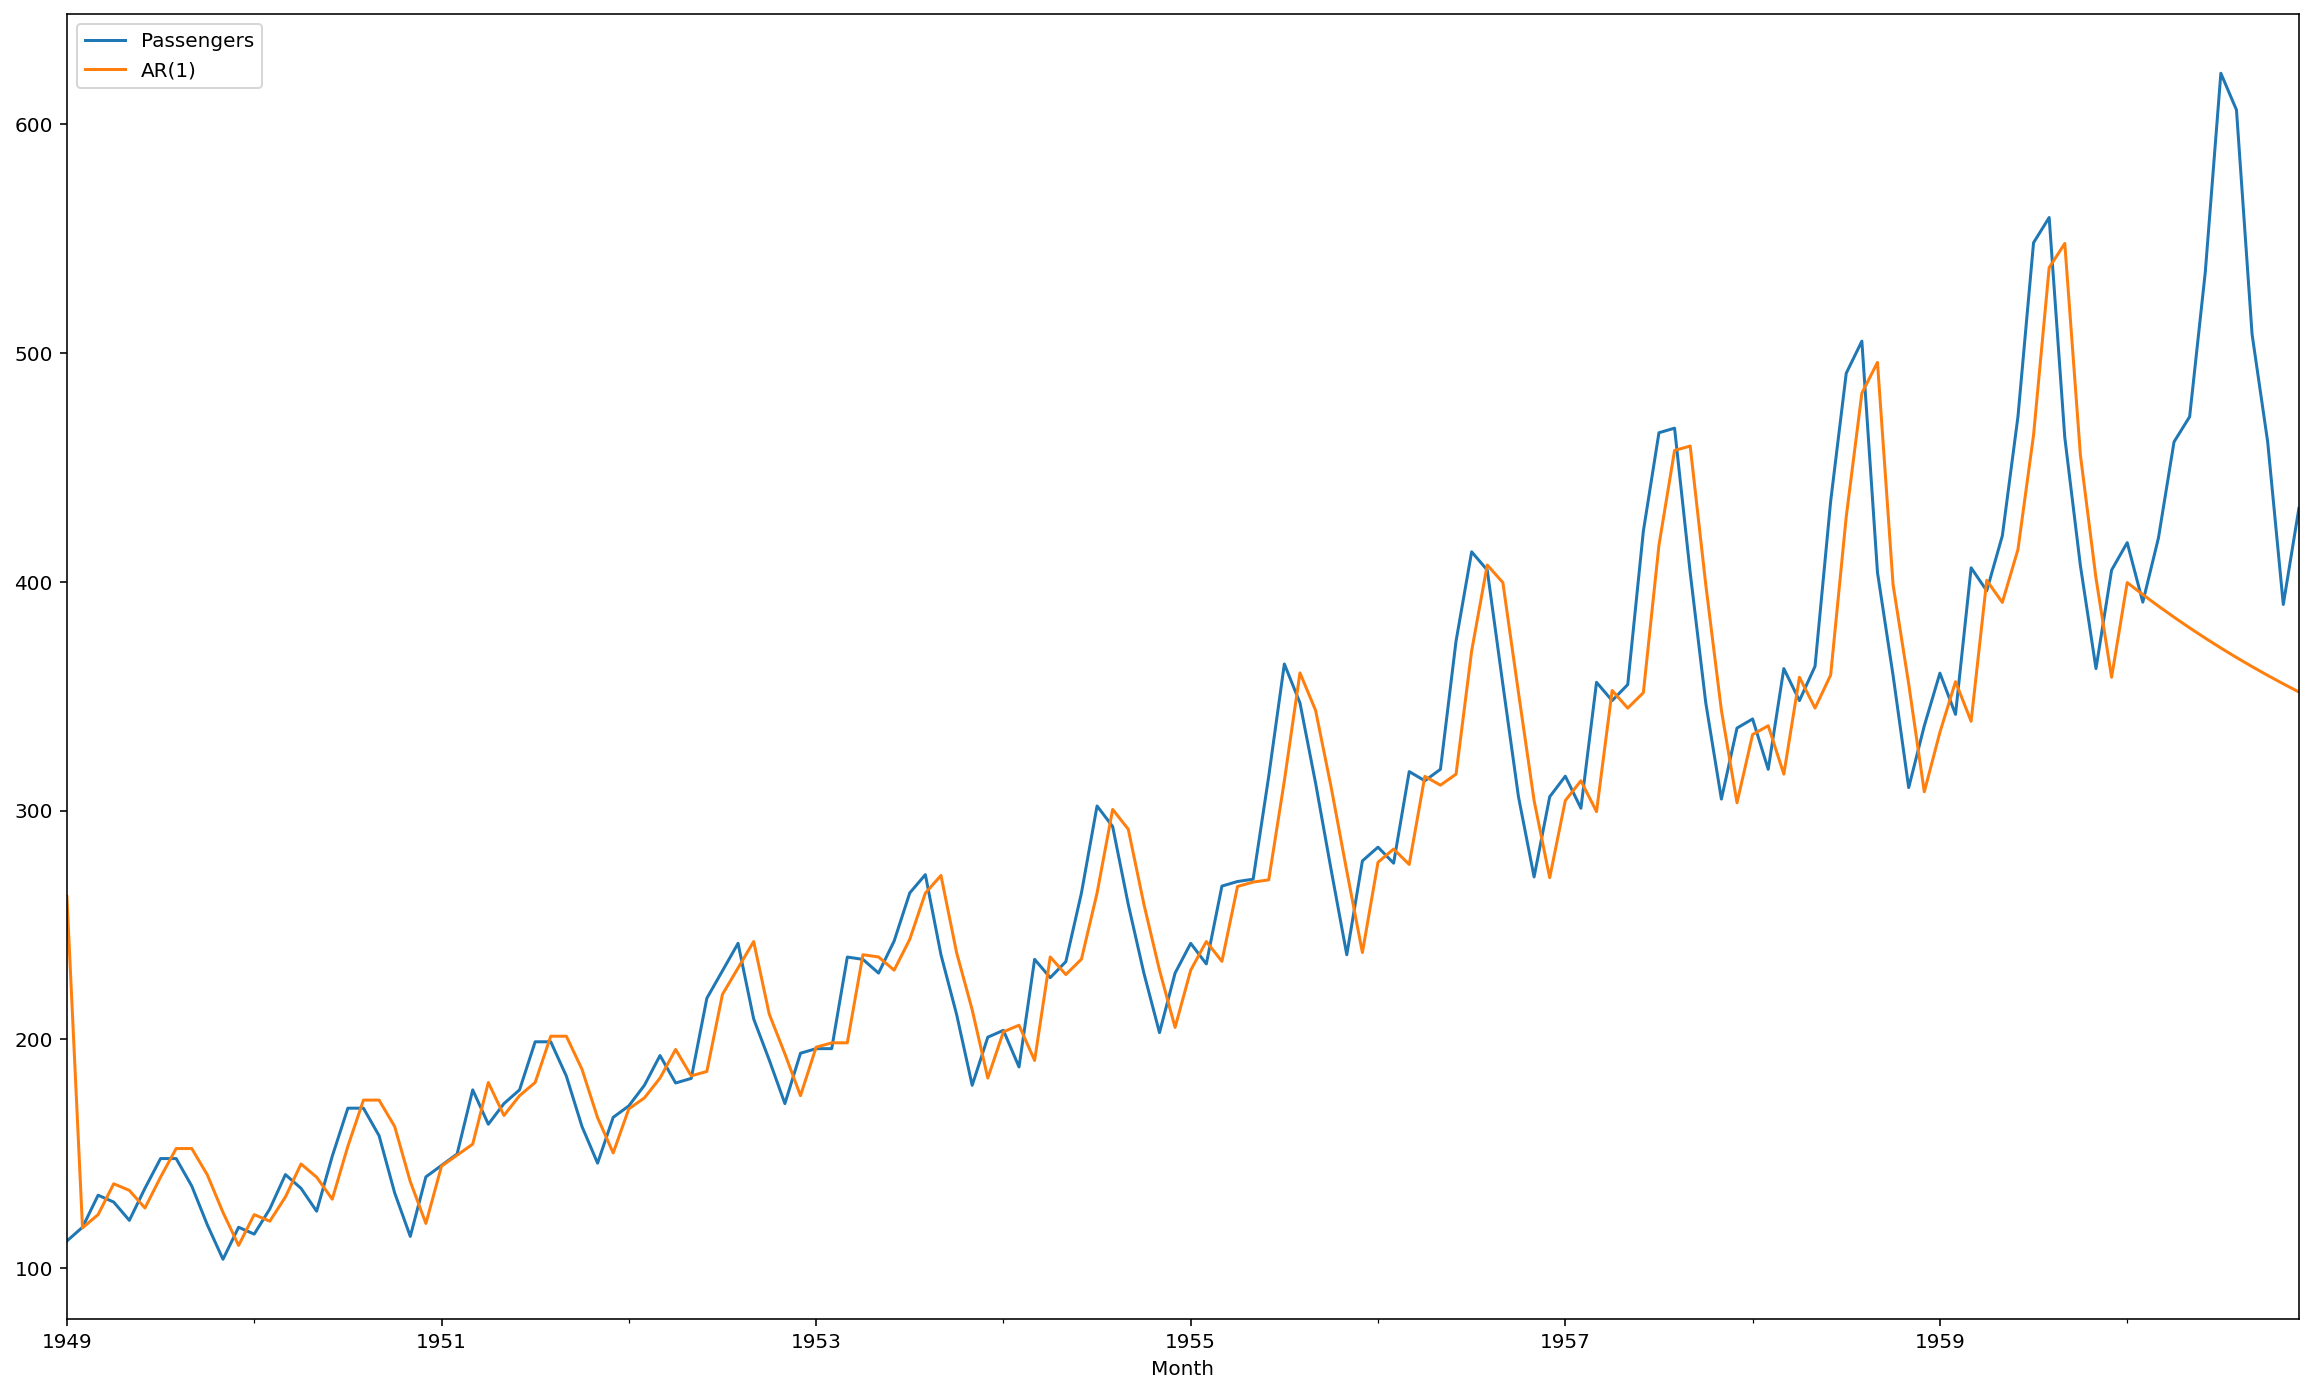

In [96]:
df[['Passengers', 'AR(1)']].plot(figsize=(20,12));

In [97]:
# Explore prediction result
type(prediction_result)

statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper

In [98]:
# Confidence interval
prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [99]:
def plot_fit_and_forecast(arima_result):
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(df['Passengers'], label='Data')
    
    # plot curve on train set
    train_pred = arima_result.fittedvalues
    ax.plot(train.index.to_numpy(), train_pred.to_numpy(), color='green', label='fitted')
    
    # forecast the test set
    prediction_result = arima_result.get_forecast(N_test)
    conf_int = prediction_result.conf_int()
    lowwer, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index.to_numpy(), forecast.to_numpy(), label='forecast')
    ax.fill_between(test.index, lowwer, upper, color='Red', alpha=0.2)
    ax.legend()
    

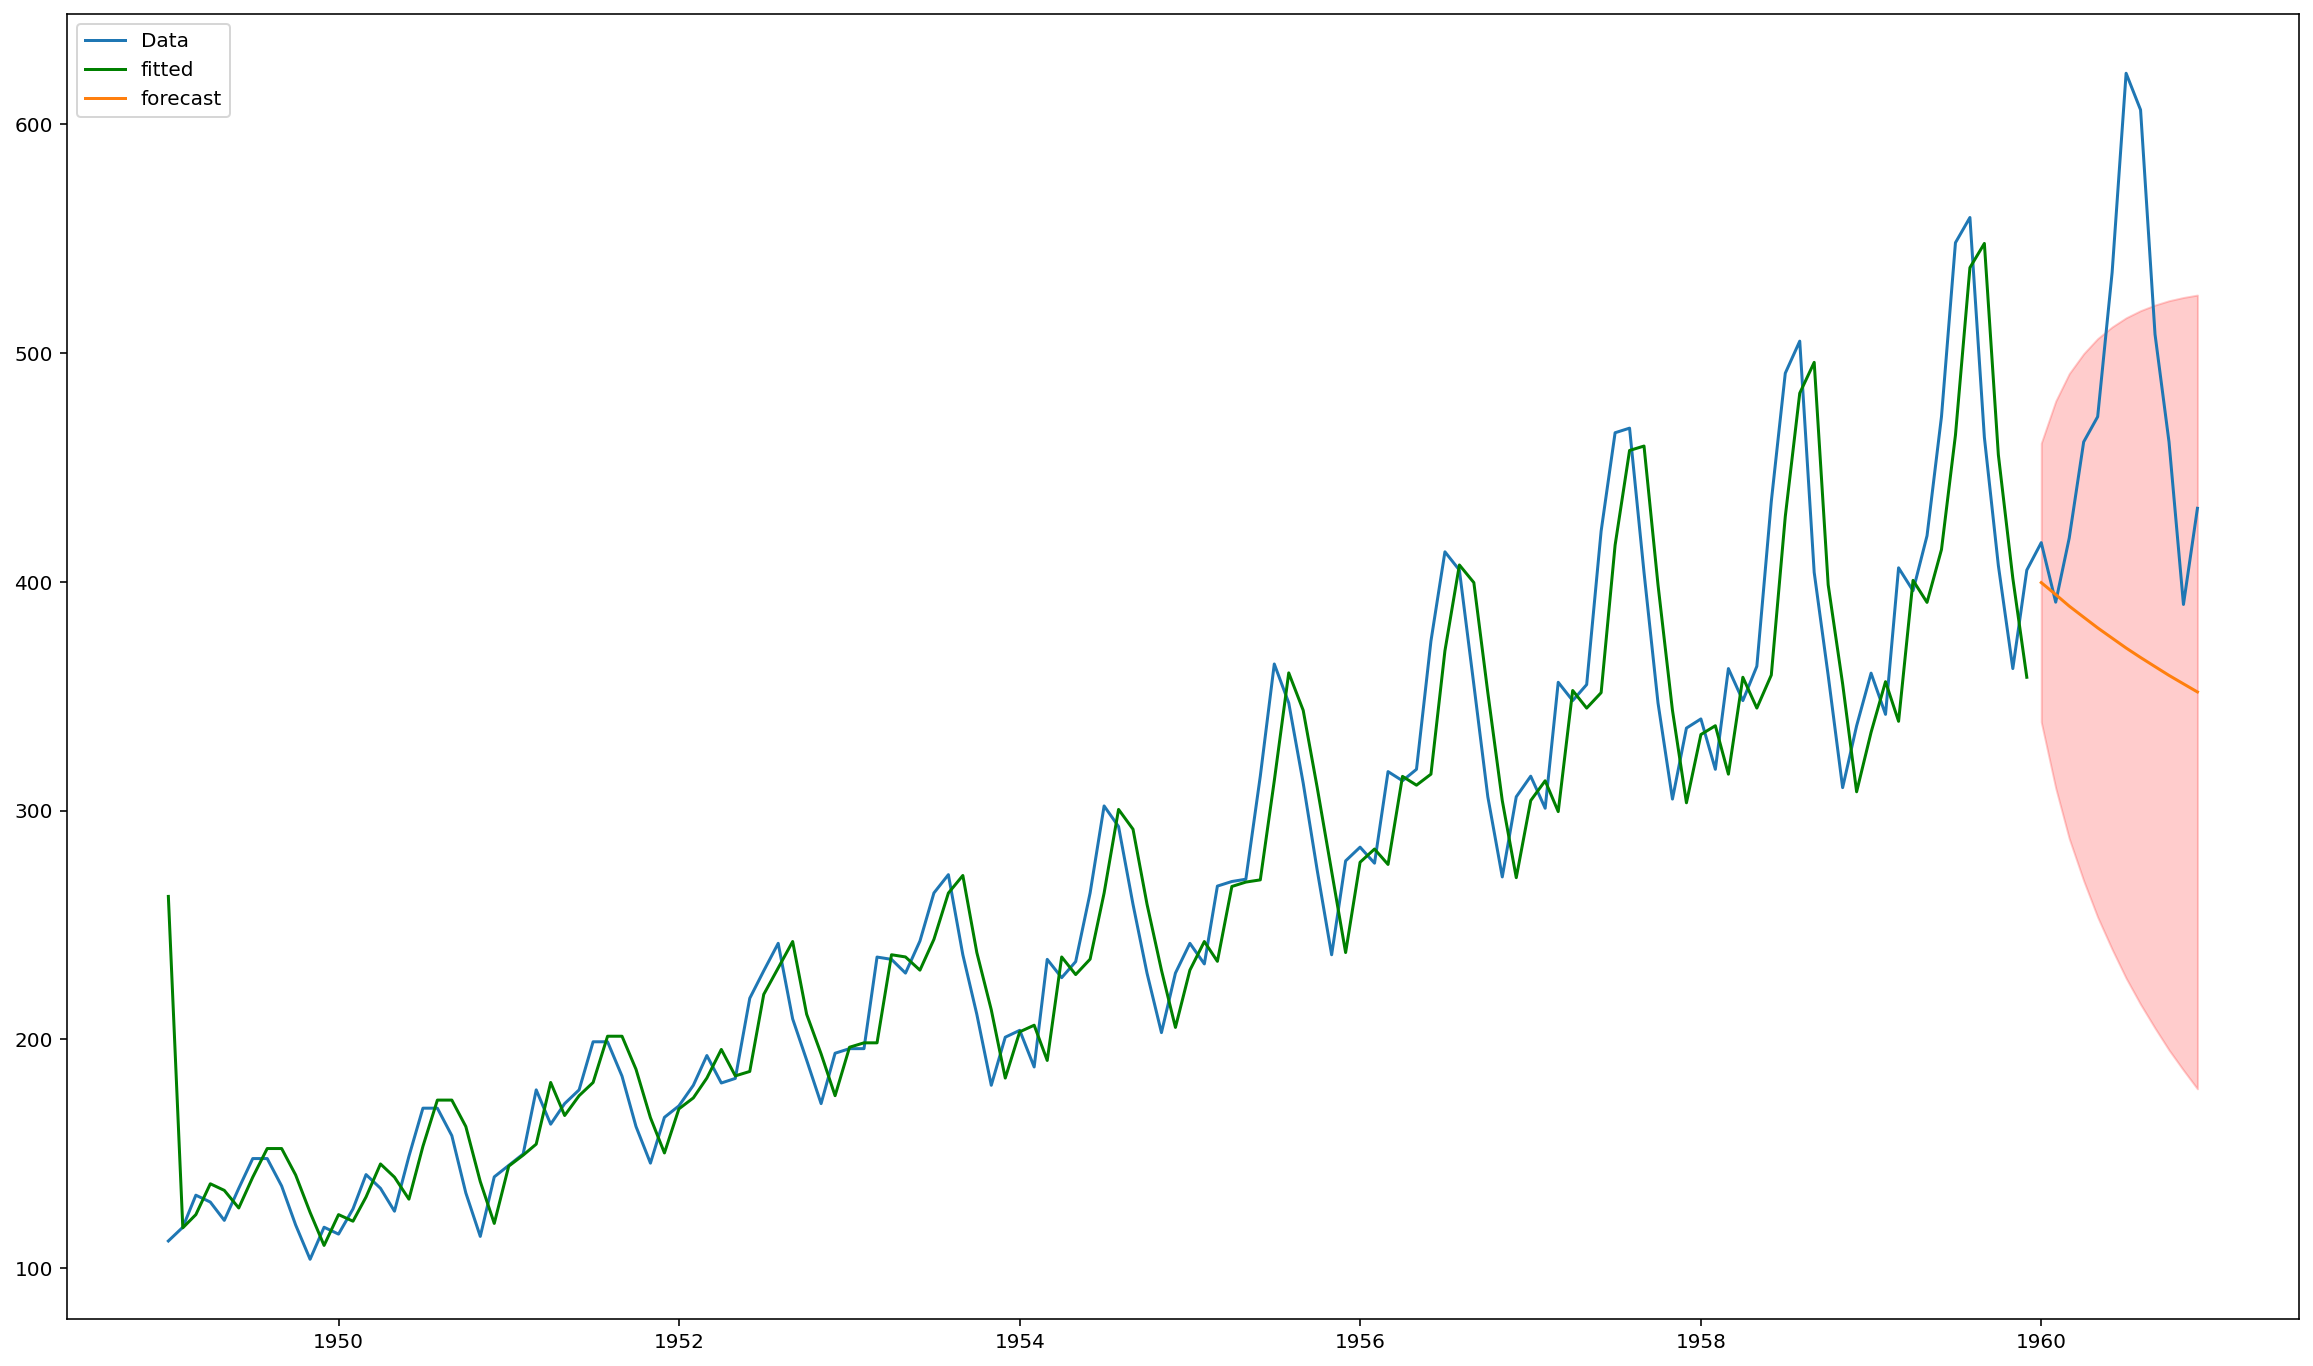

In [100]:
plot_fit_and_forecast(arima_result)

# Добавим больше inputs in AR

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


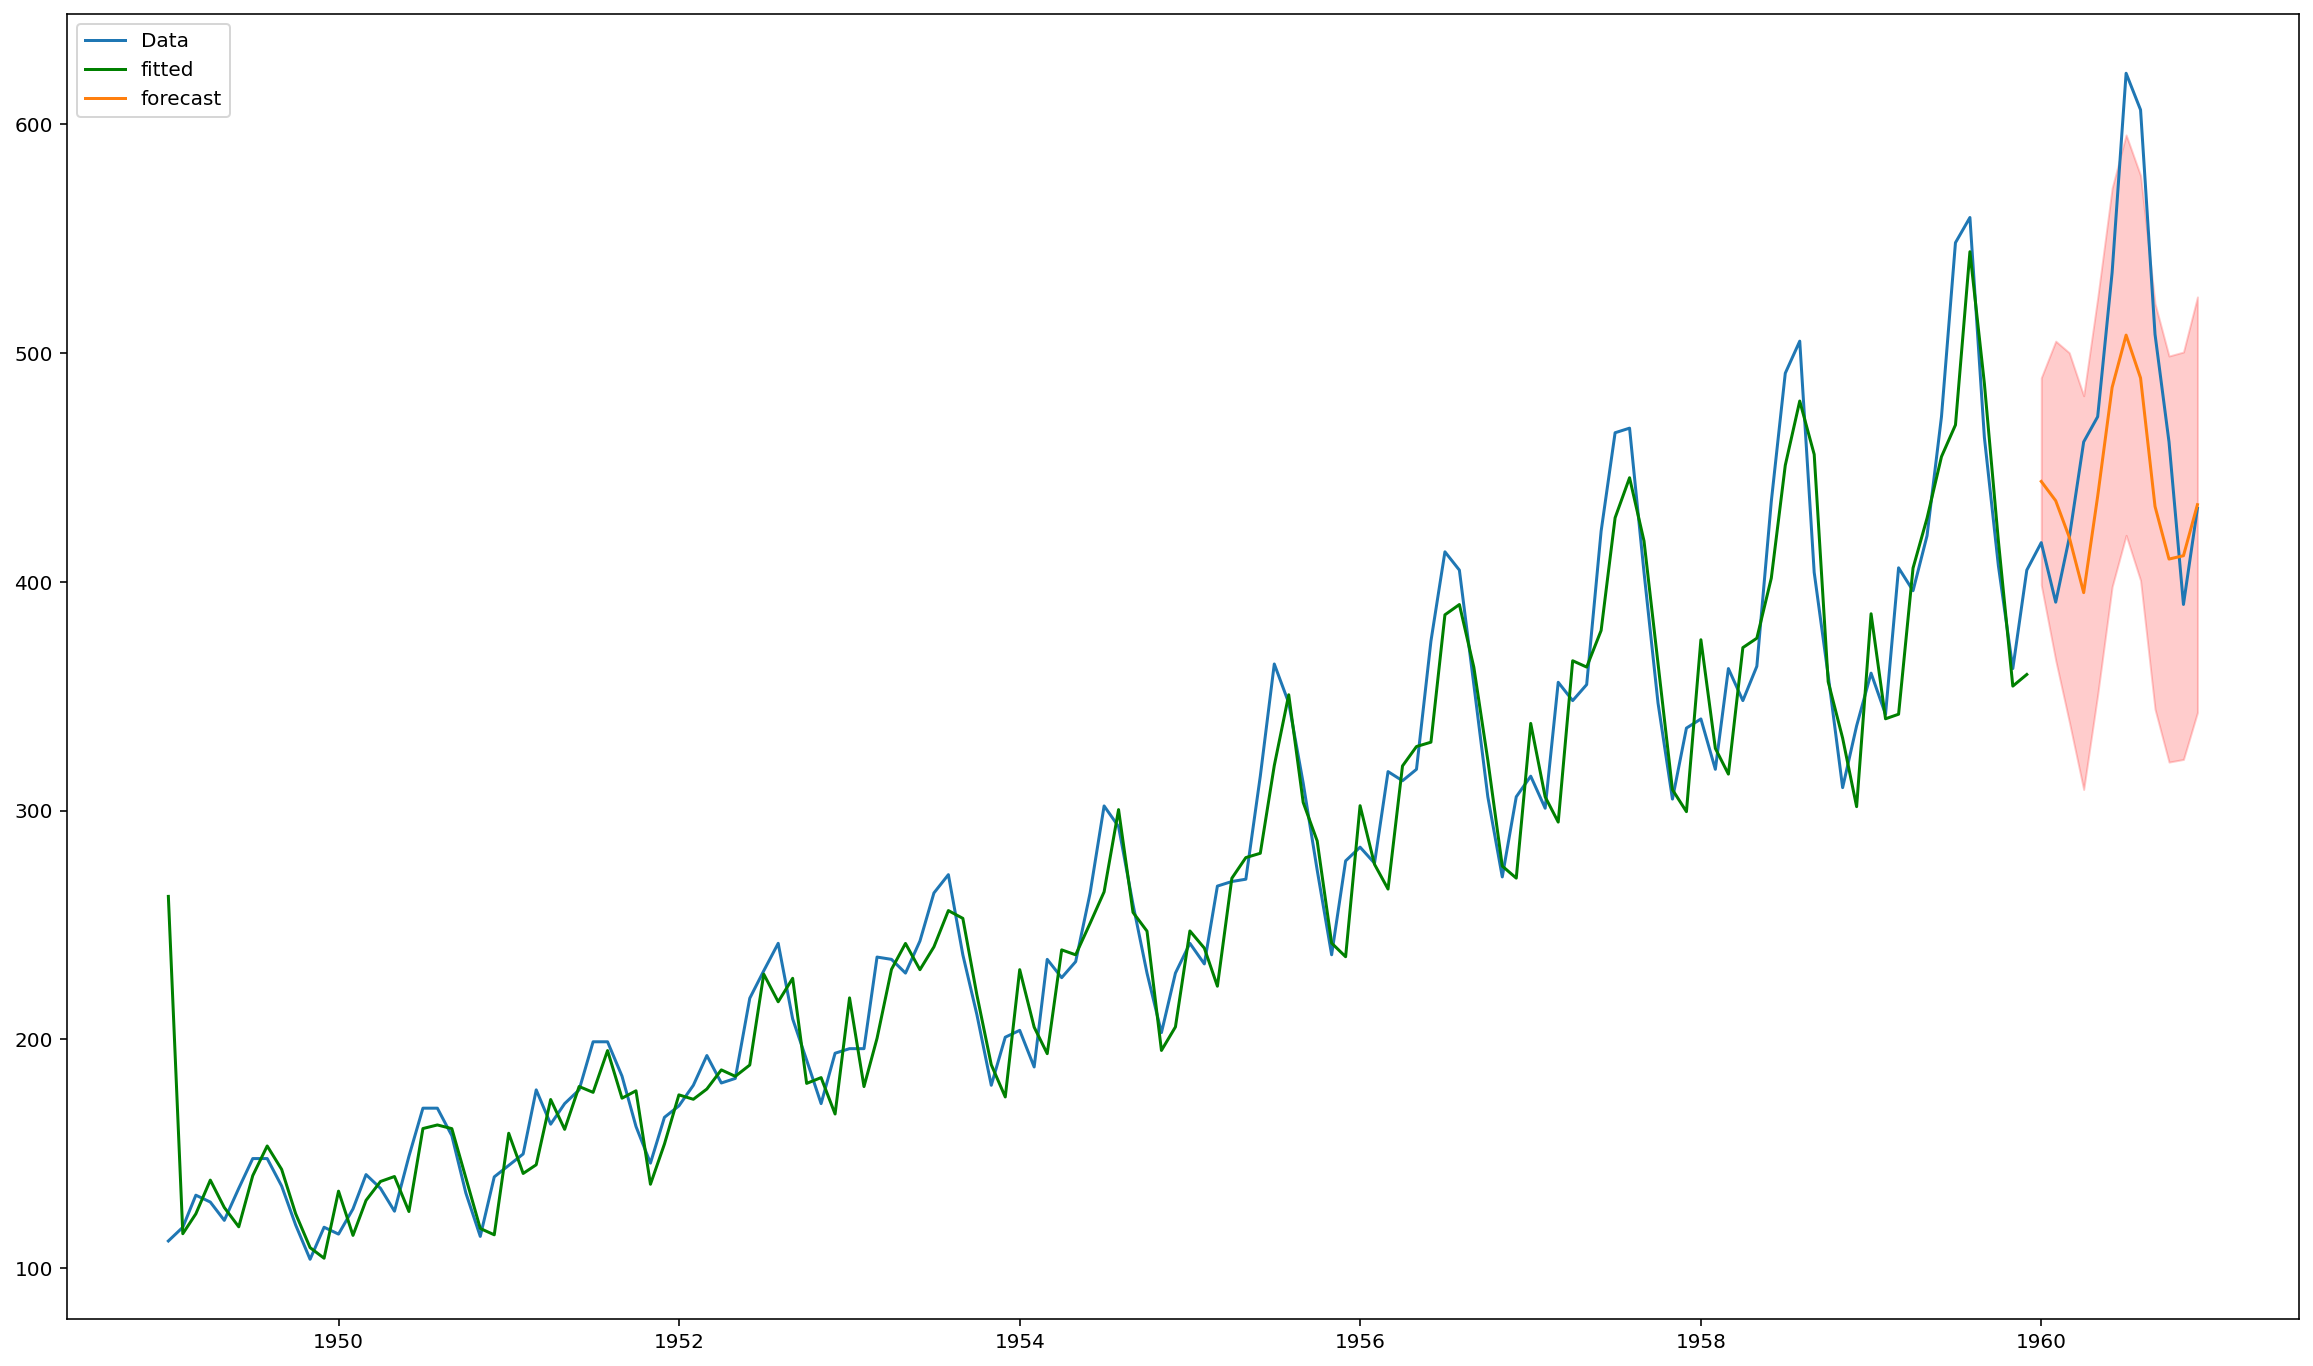

In [101]:
# AR(10)
arima = ARIMA(train['Passengers'], order=(10, 0, 0))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)


С 10 признаками в последовательности исторических данных модель выглядит более качественно

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


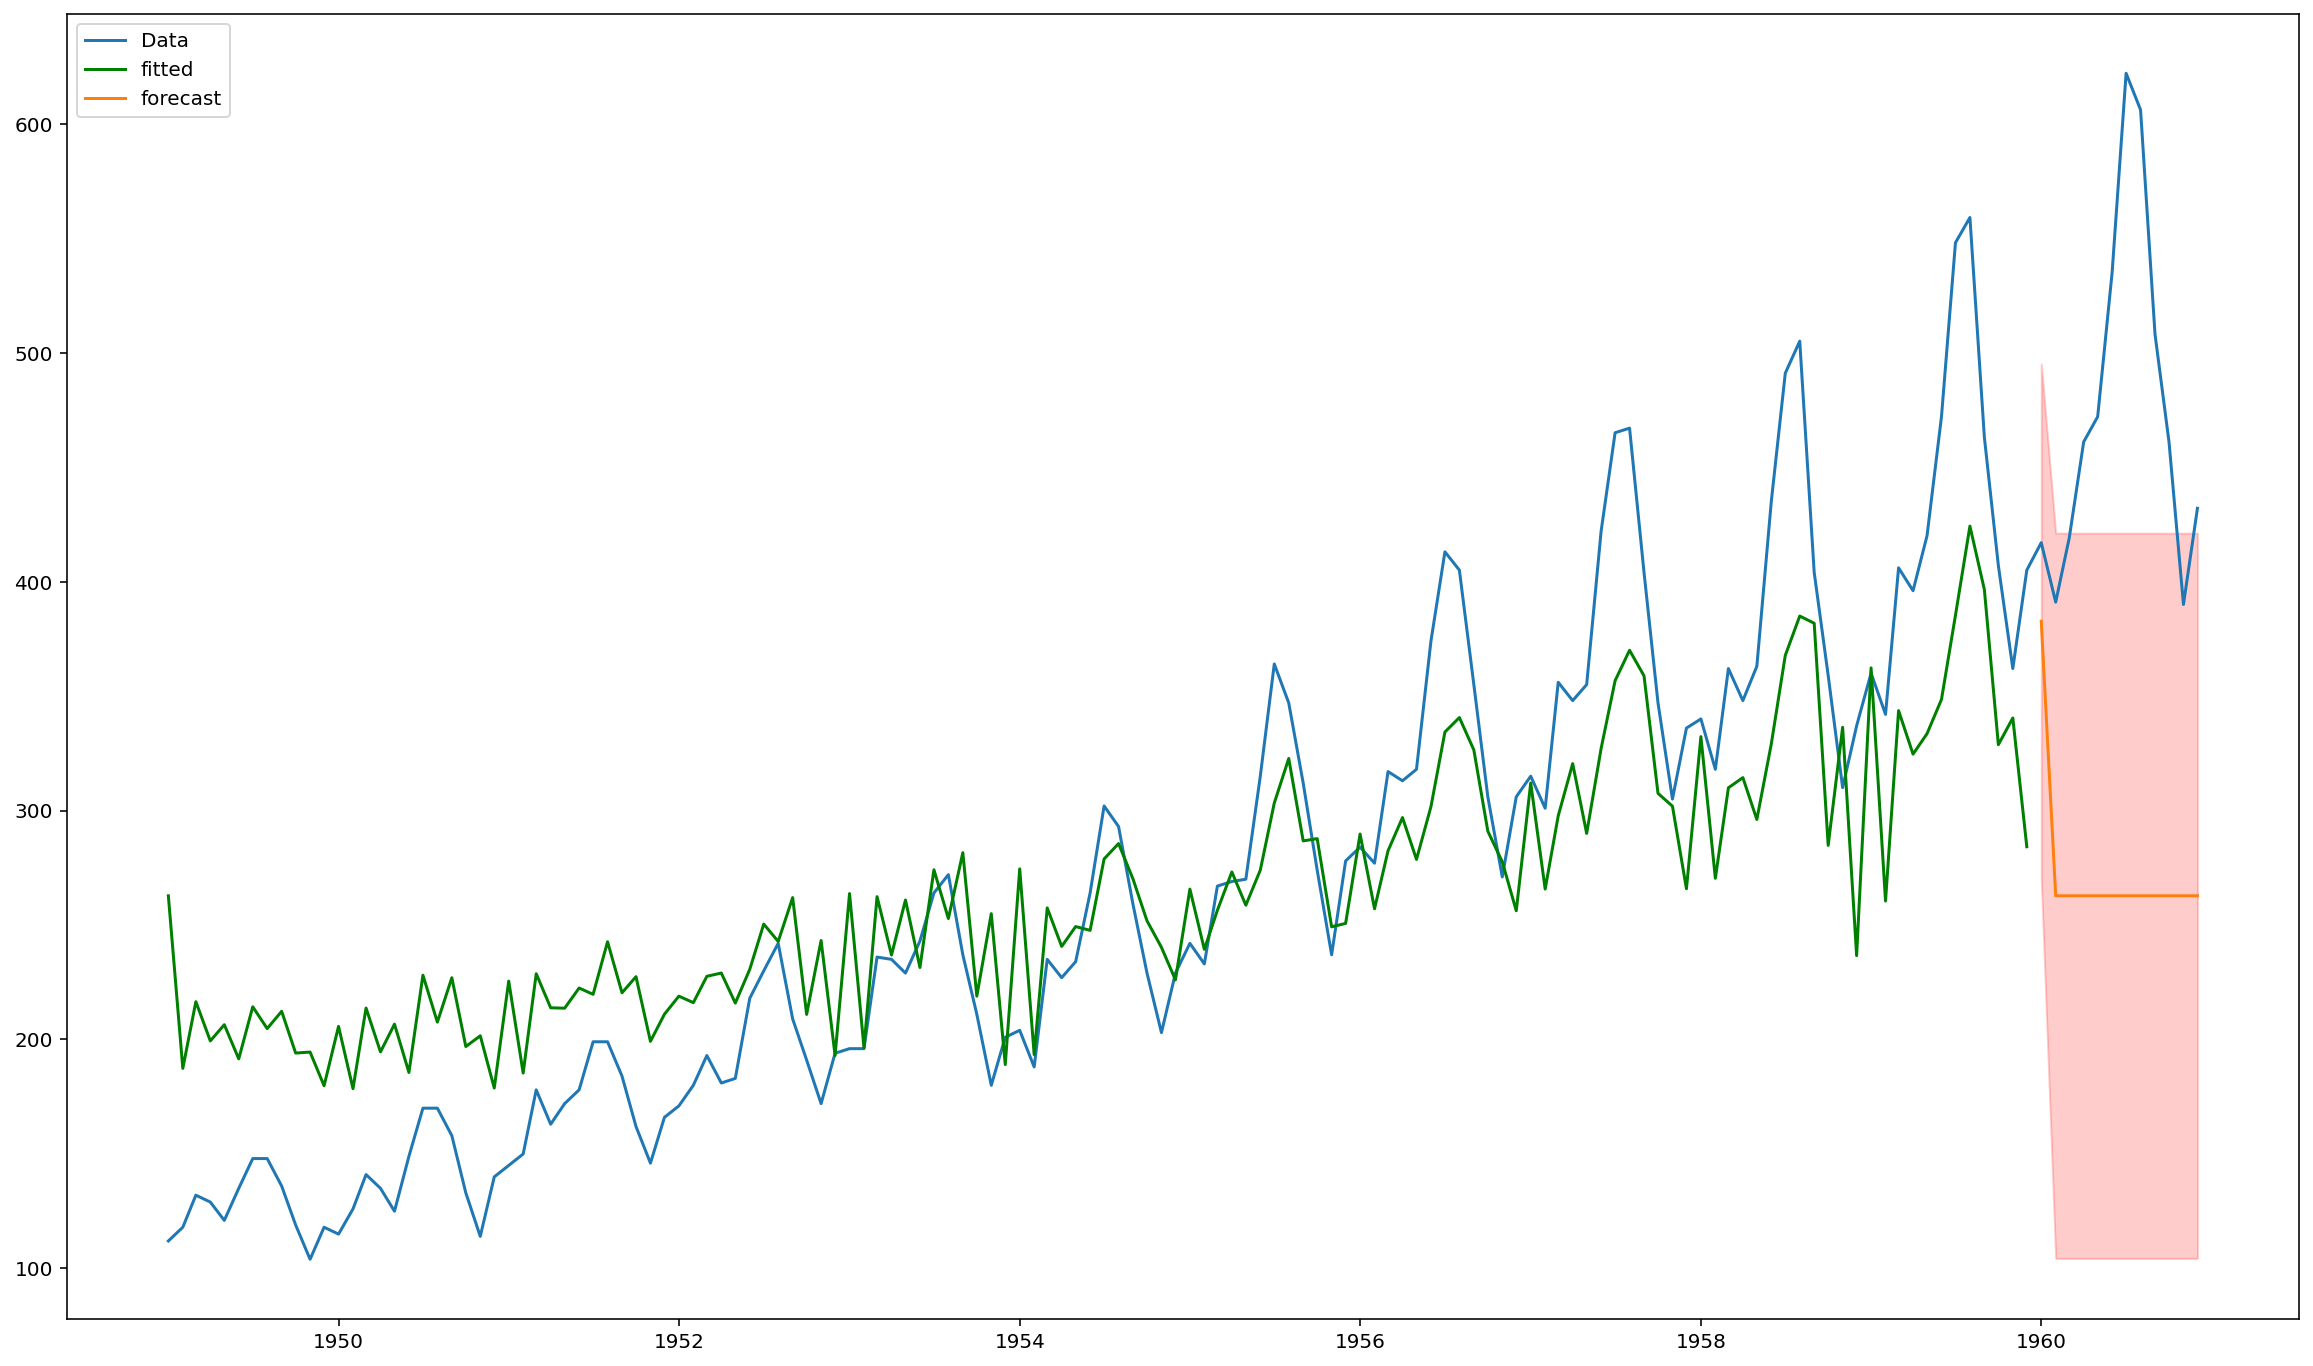

In [102]:
# MA(1)
arima = ARIMA(train['Passengers'], order=(0, 0, 1))
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

### Пробуем перейти к логарифмической первой разнице
Фактически Log Return.

Тут просто визуализация, переход будет производиться в самой моделе ARIMA. Через задание параметра d=1.

In [103]:
df['Log_First_Diff'] = df['Log_Passengers'].diff()

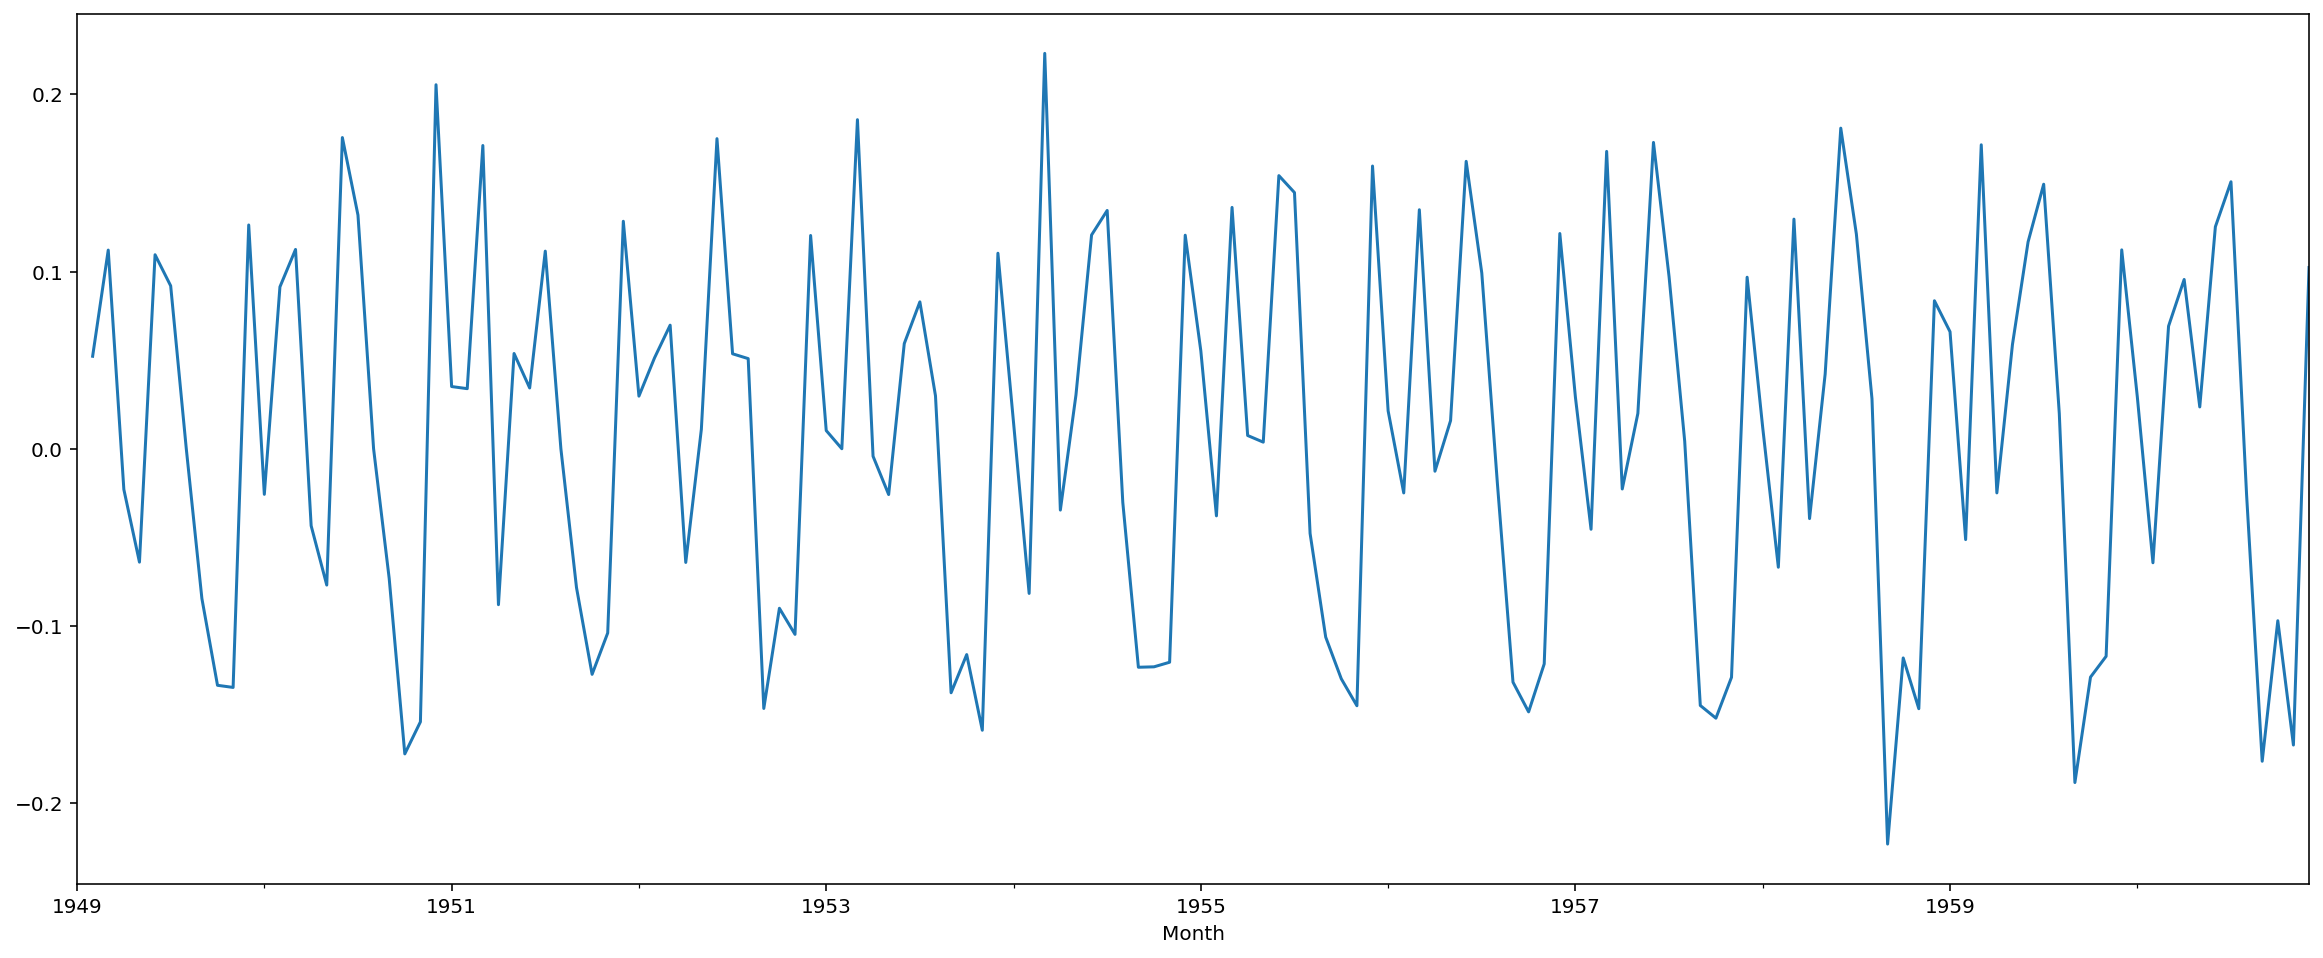

In [104]:
df['Log_First_Diff'].plot(figsize=(20, 8));

In [105]:
def plot_fit_and_forecast_int(arima_result, d, col='Passengers'):
    """_summary_

    Args:
        arima_result (_type_): _description_
        d (_type_): d-value - setting for ARIMA model 
        col (str, optional): _description_. Defaults to 'Passengers'.
    """
    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(df[col], label='Data')
    
    # plot curve on train set
    train_pred = arima_result.predict(start=train.index[d], end=train.index[-1])
    ax.plot(train.index[d:].to_numpy(), train_pred.to_numpy(), color='green', label='fitted')
    
    # forecast the test set
    prediction_result = arima_result.get_forecast(N_test)
    conf_int = prediction_result.conf_int()
    lowwer, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index.to_numpy(), forecast.to_numpy(), label='forecast')
    ax.fill_between(test.index, lowwer, upper, color='Red', alpha=0.2)
    ax.legend()

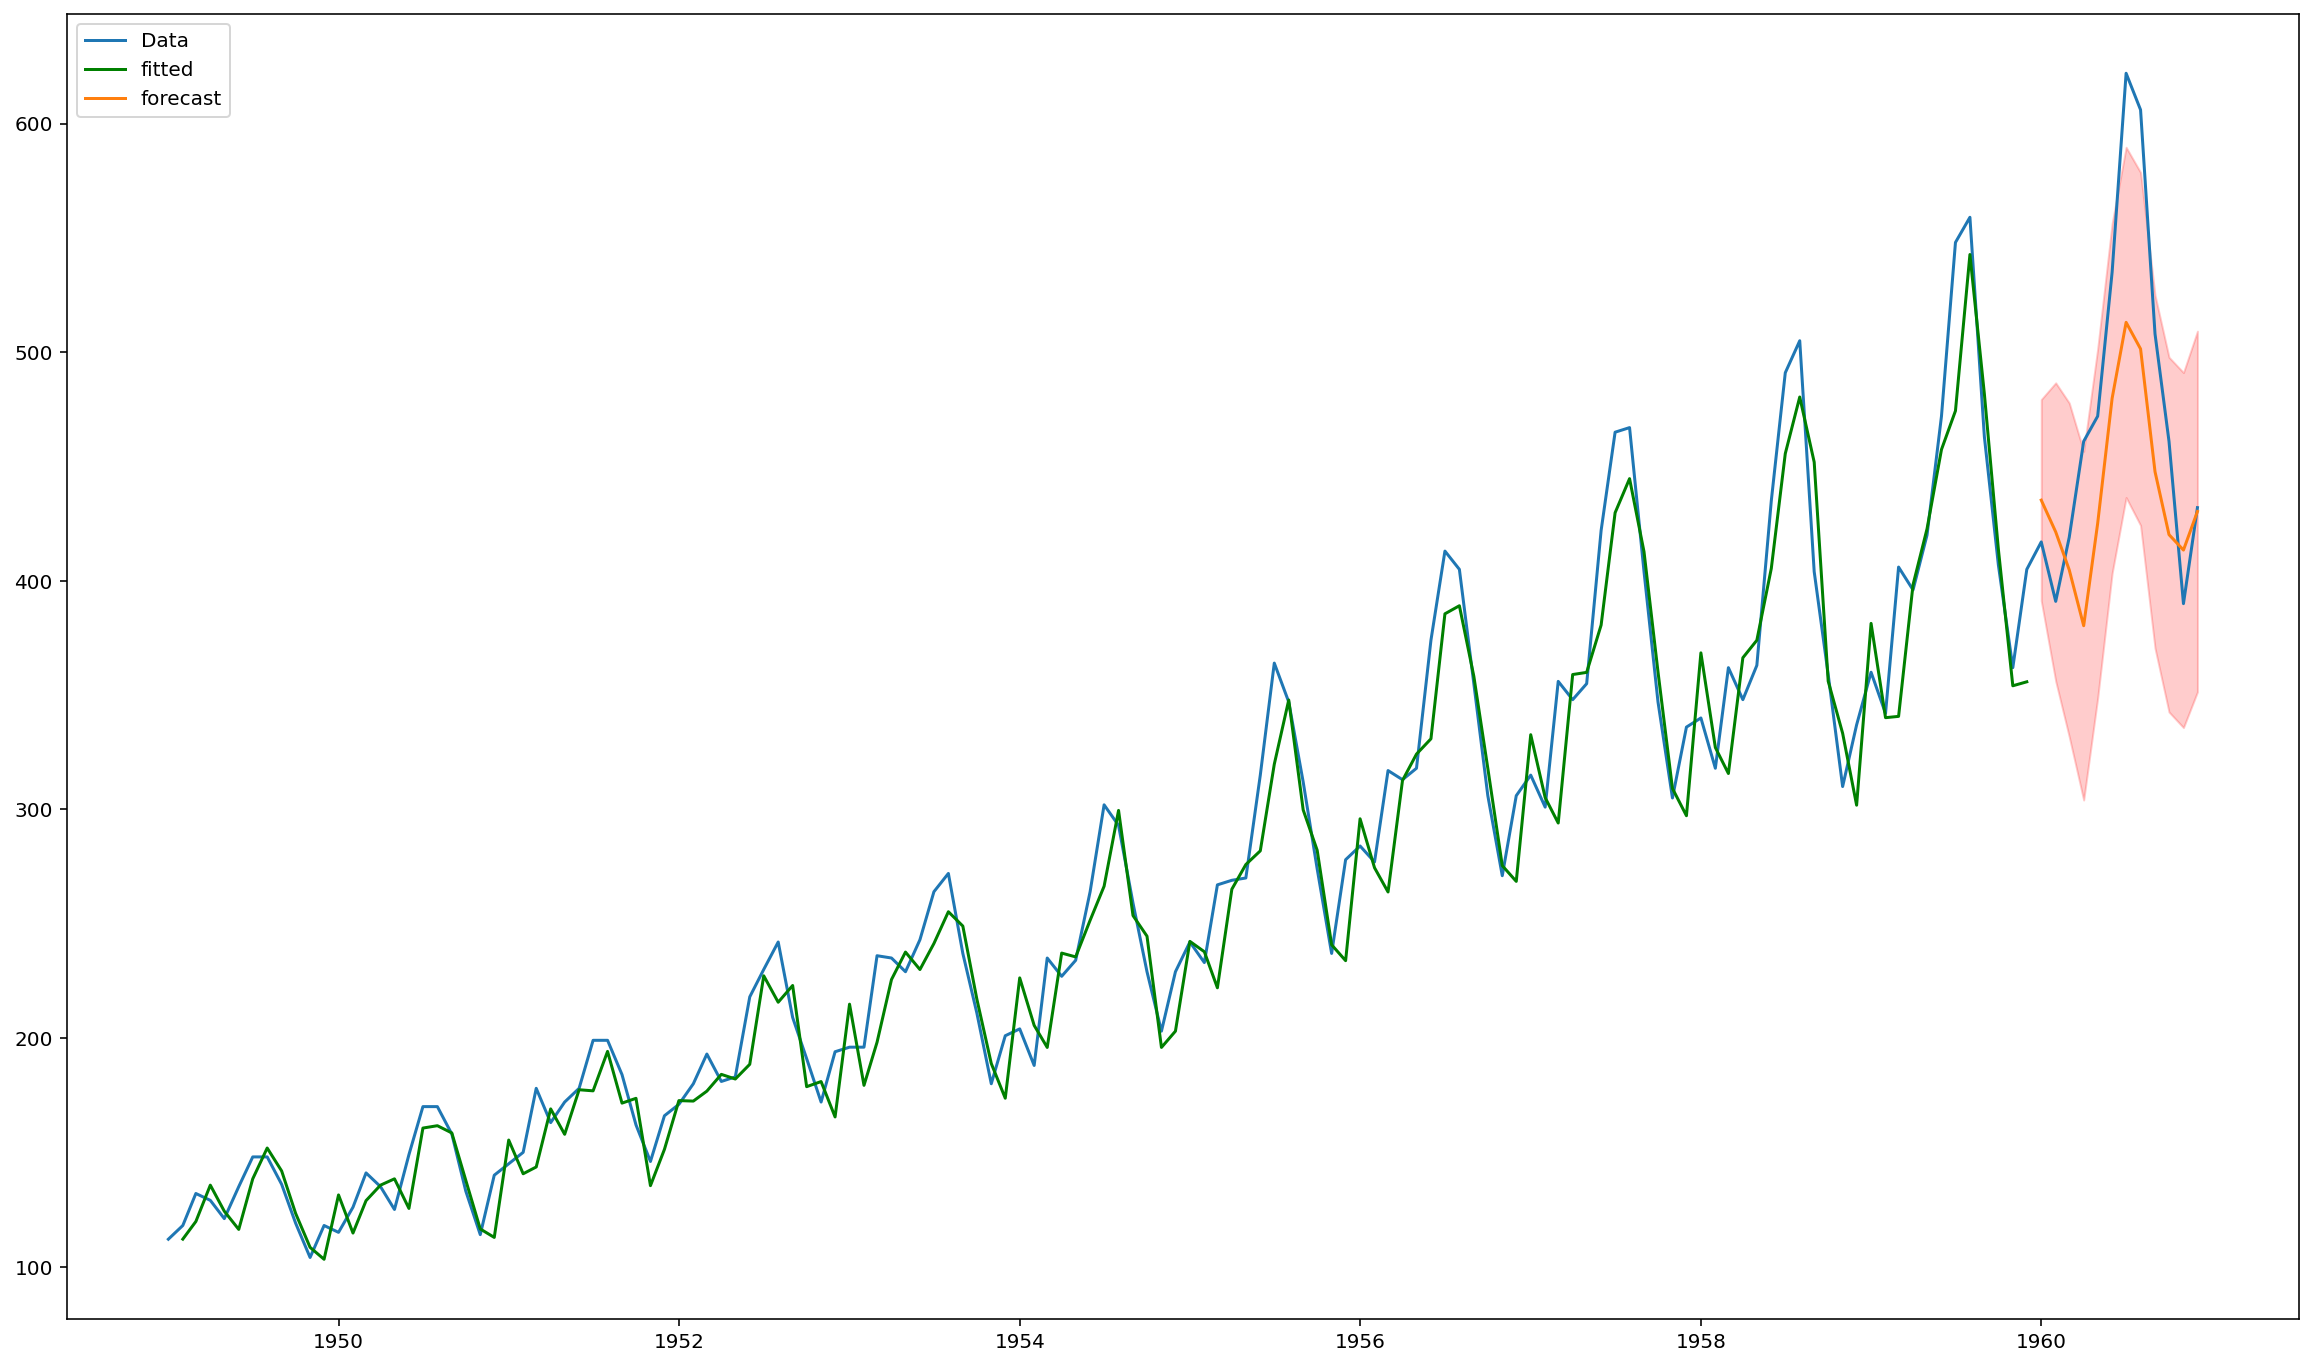

In [106]:
plot_fit_and_forecast_int(arima_result_811, 1)

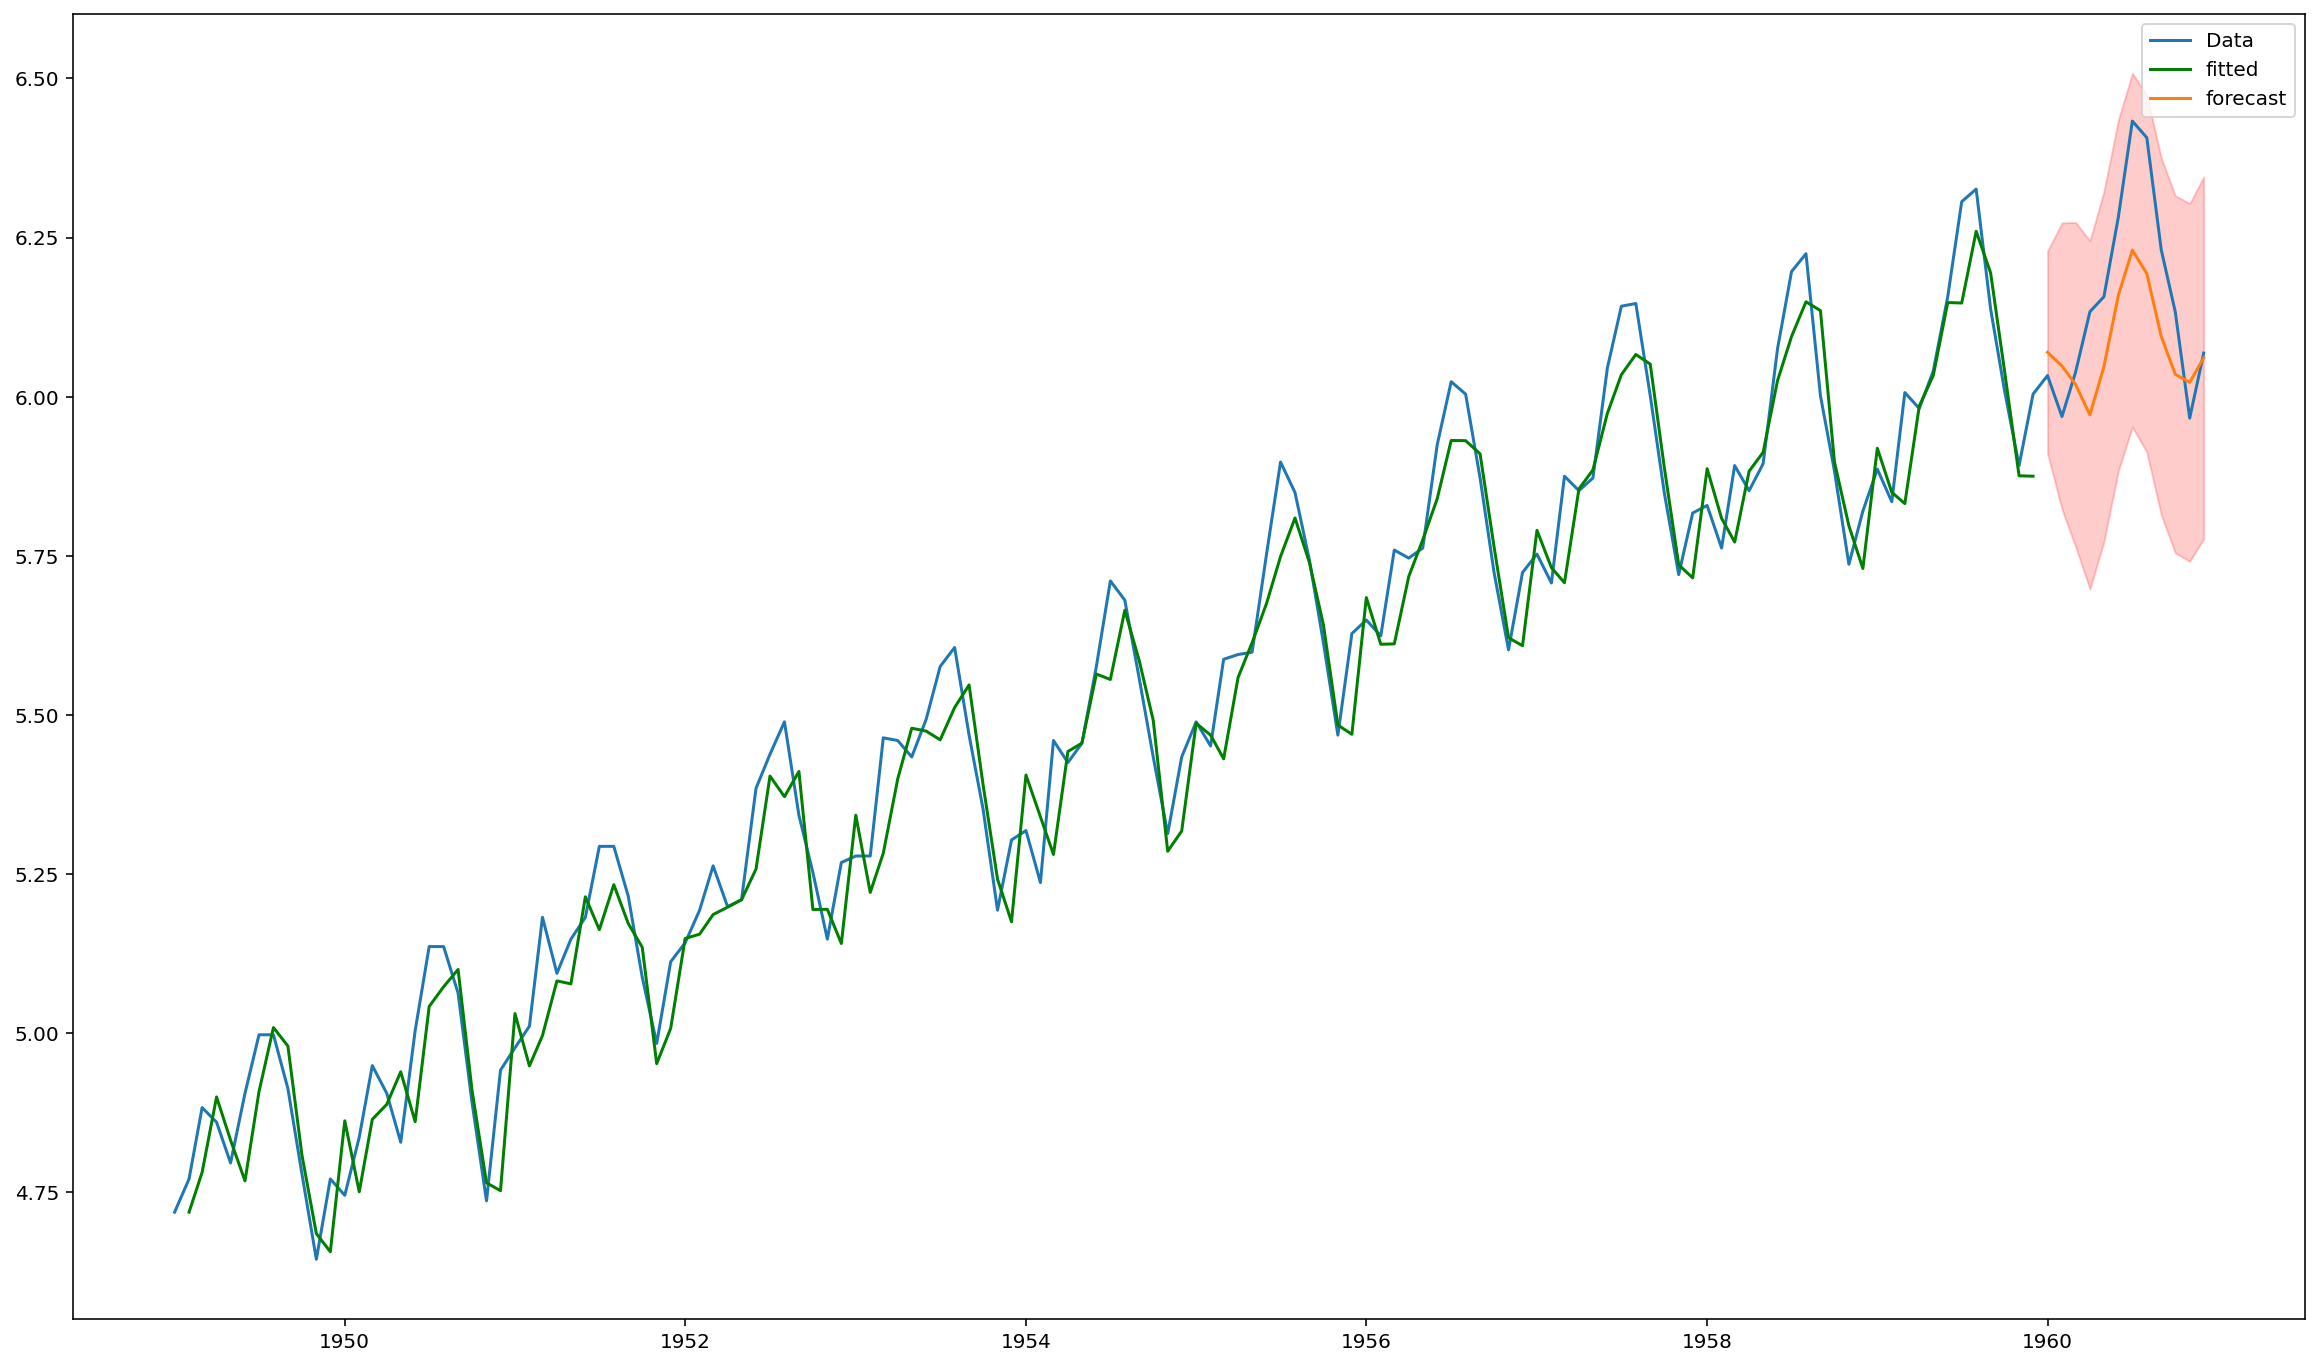

In [107]:
arima = ARIMA(train['Log_Passengers'], order=(8, 1, 1))
arima_result_811_log = arima.fit()
plot_fit_and_forecast_int(arima_result_811_log, 1, 'Log_Passengers')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


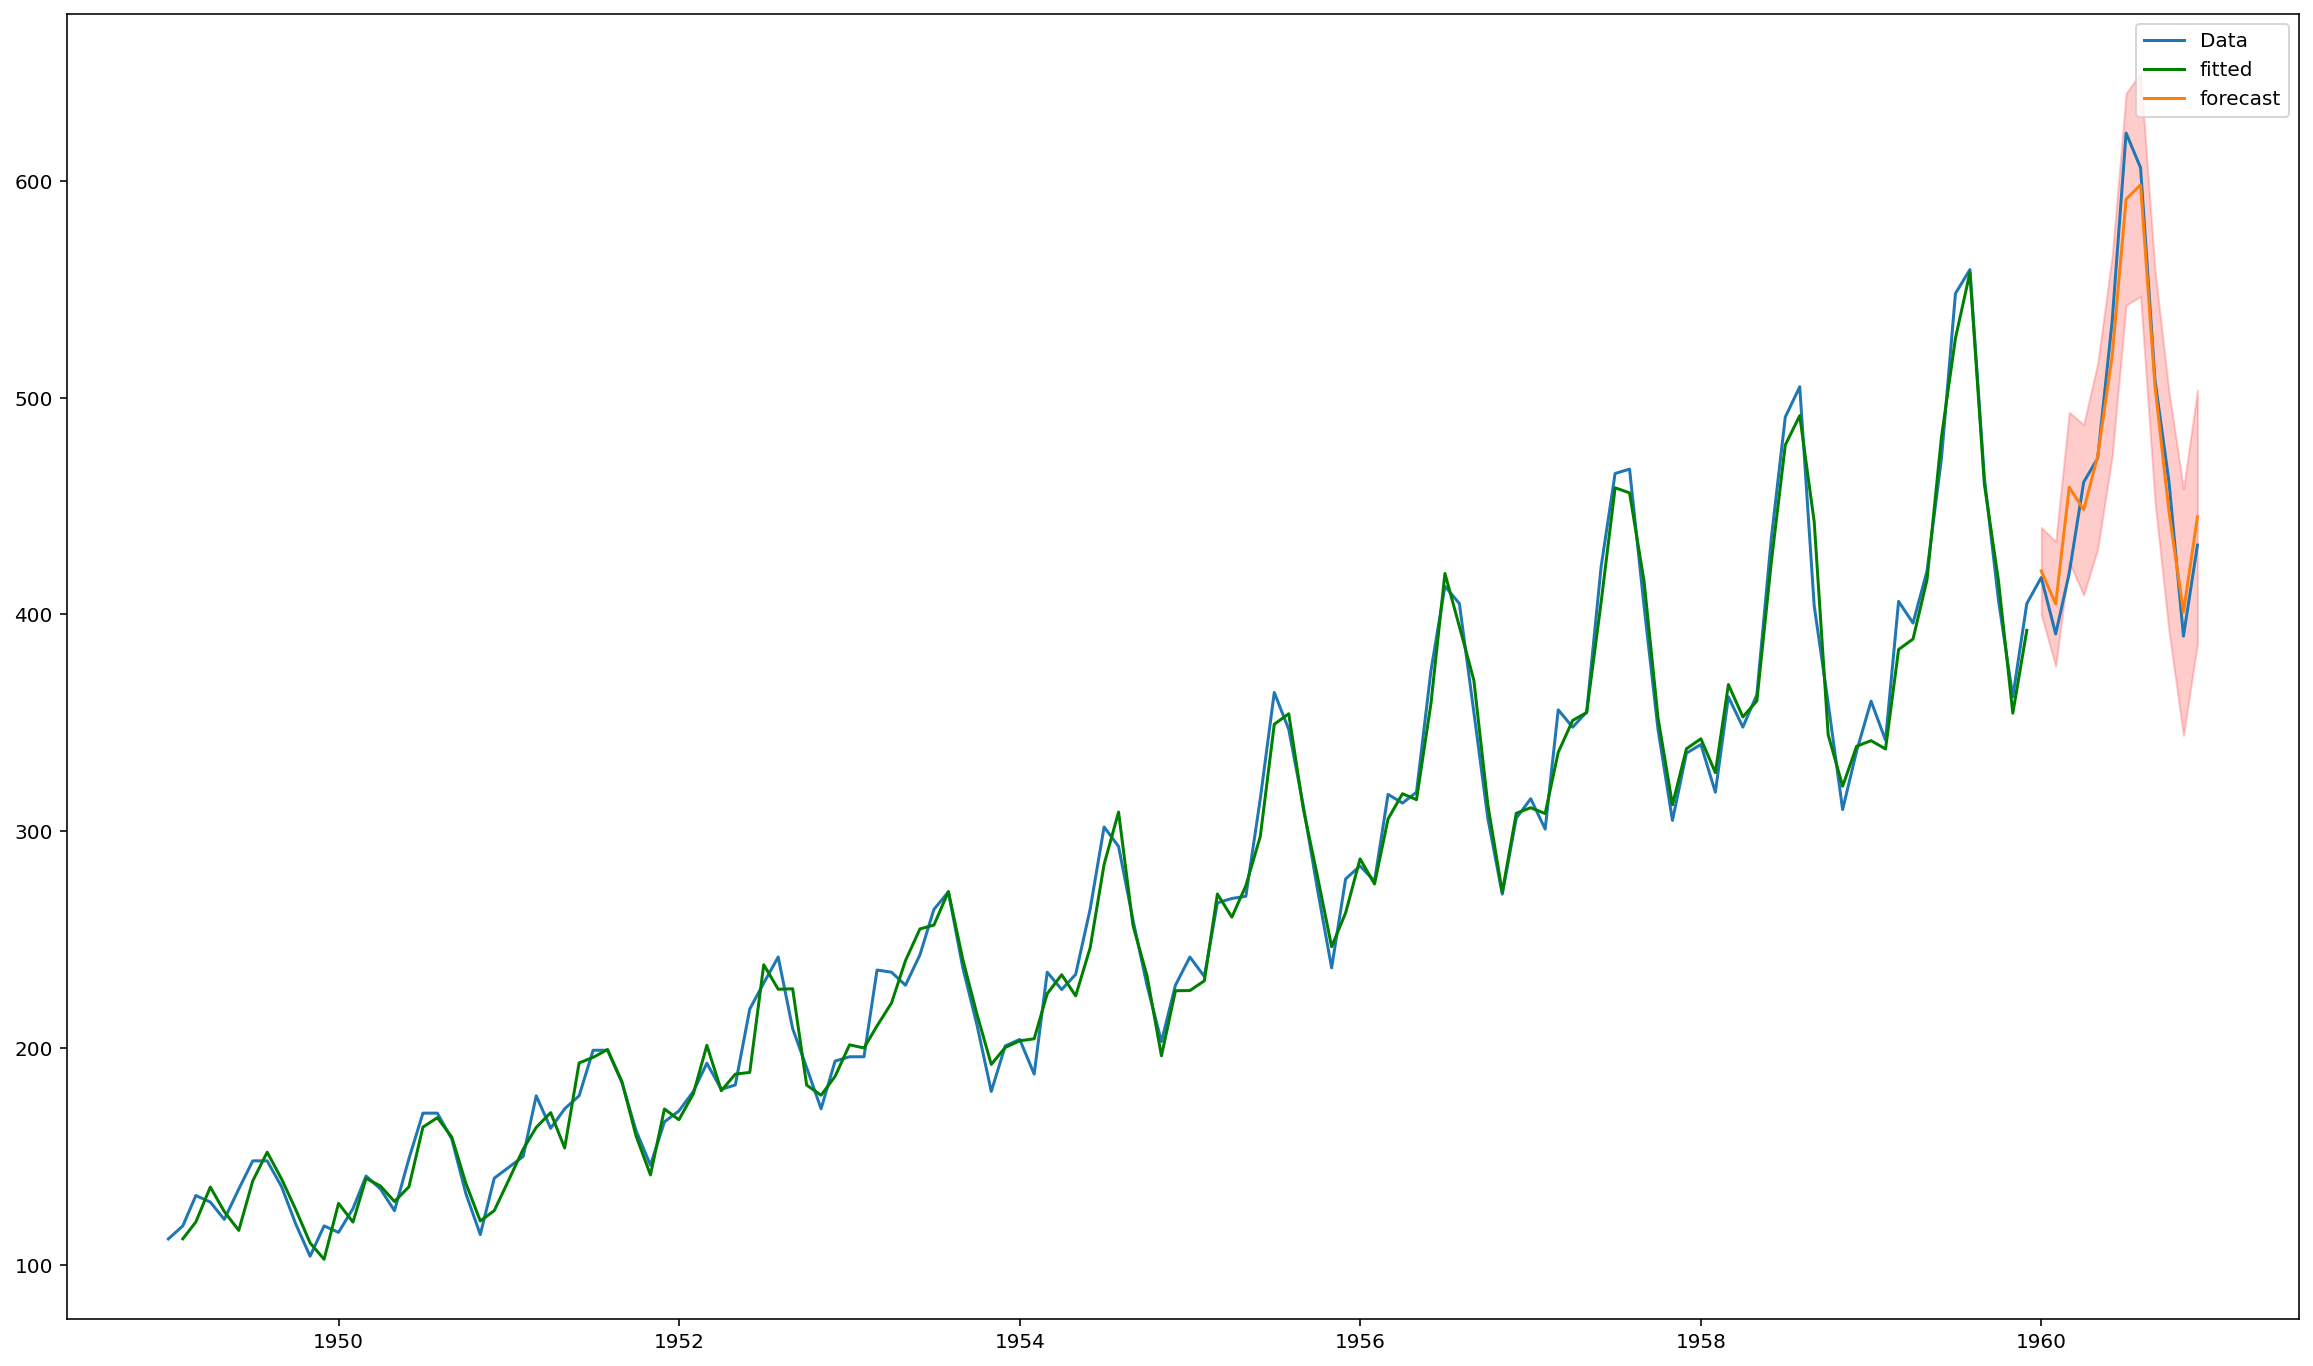

In [108]:
arima = ARIMA(train['Passengers'], order=(12, 1, 0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, 'Passengers')

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


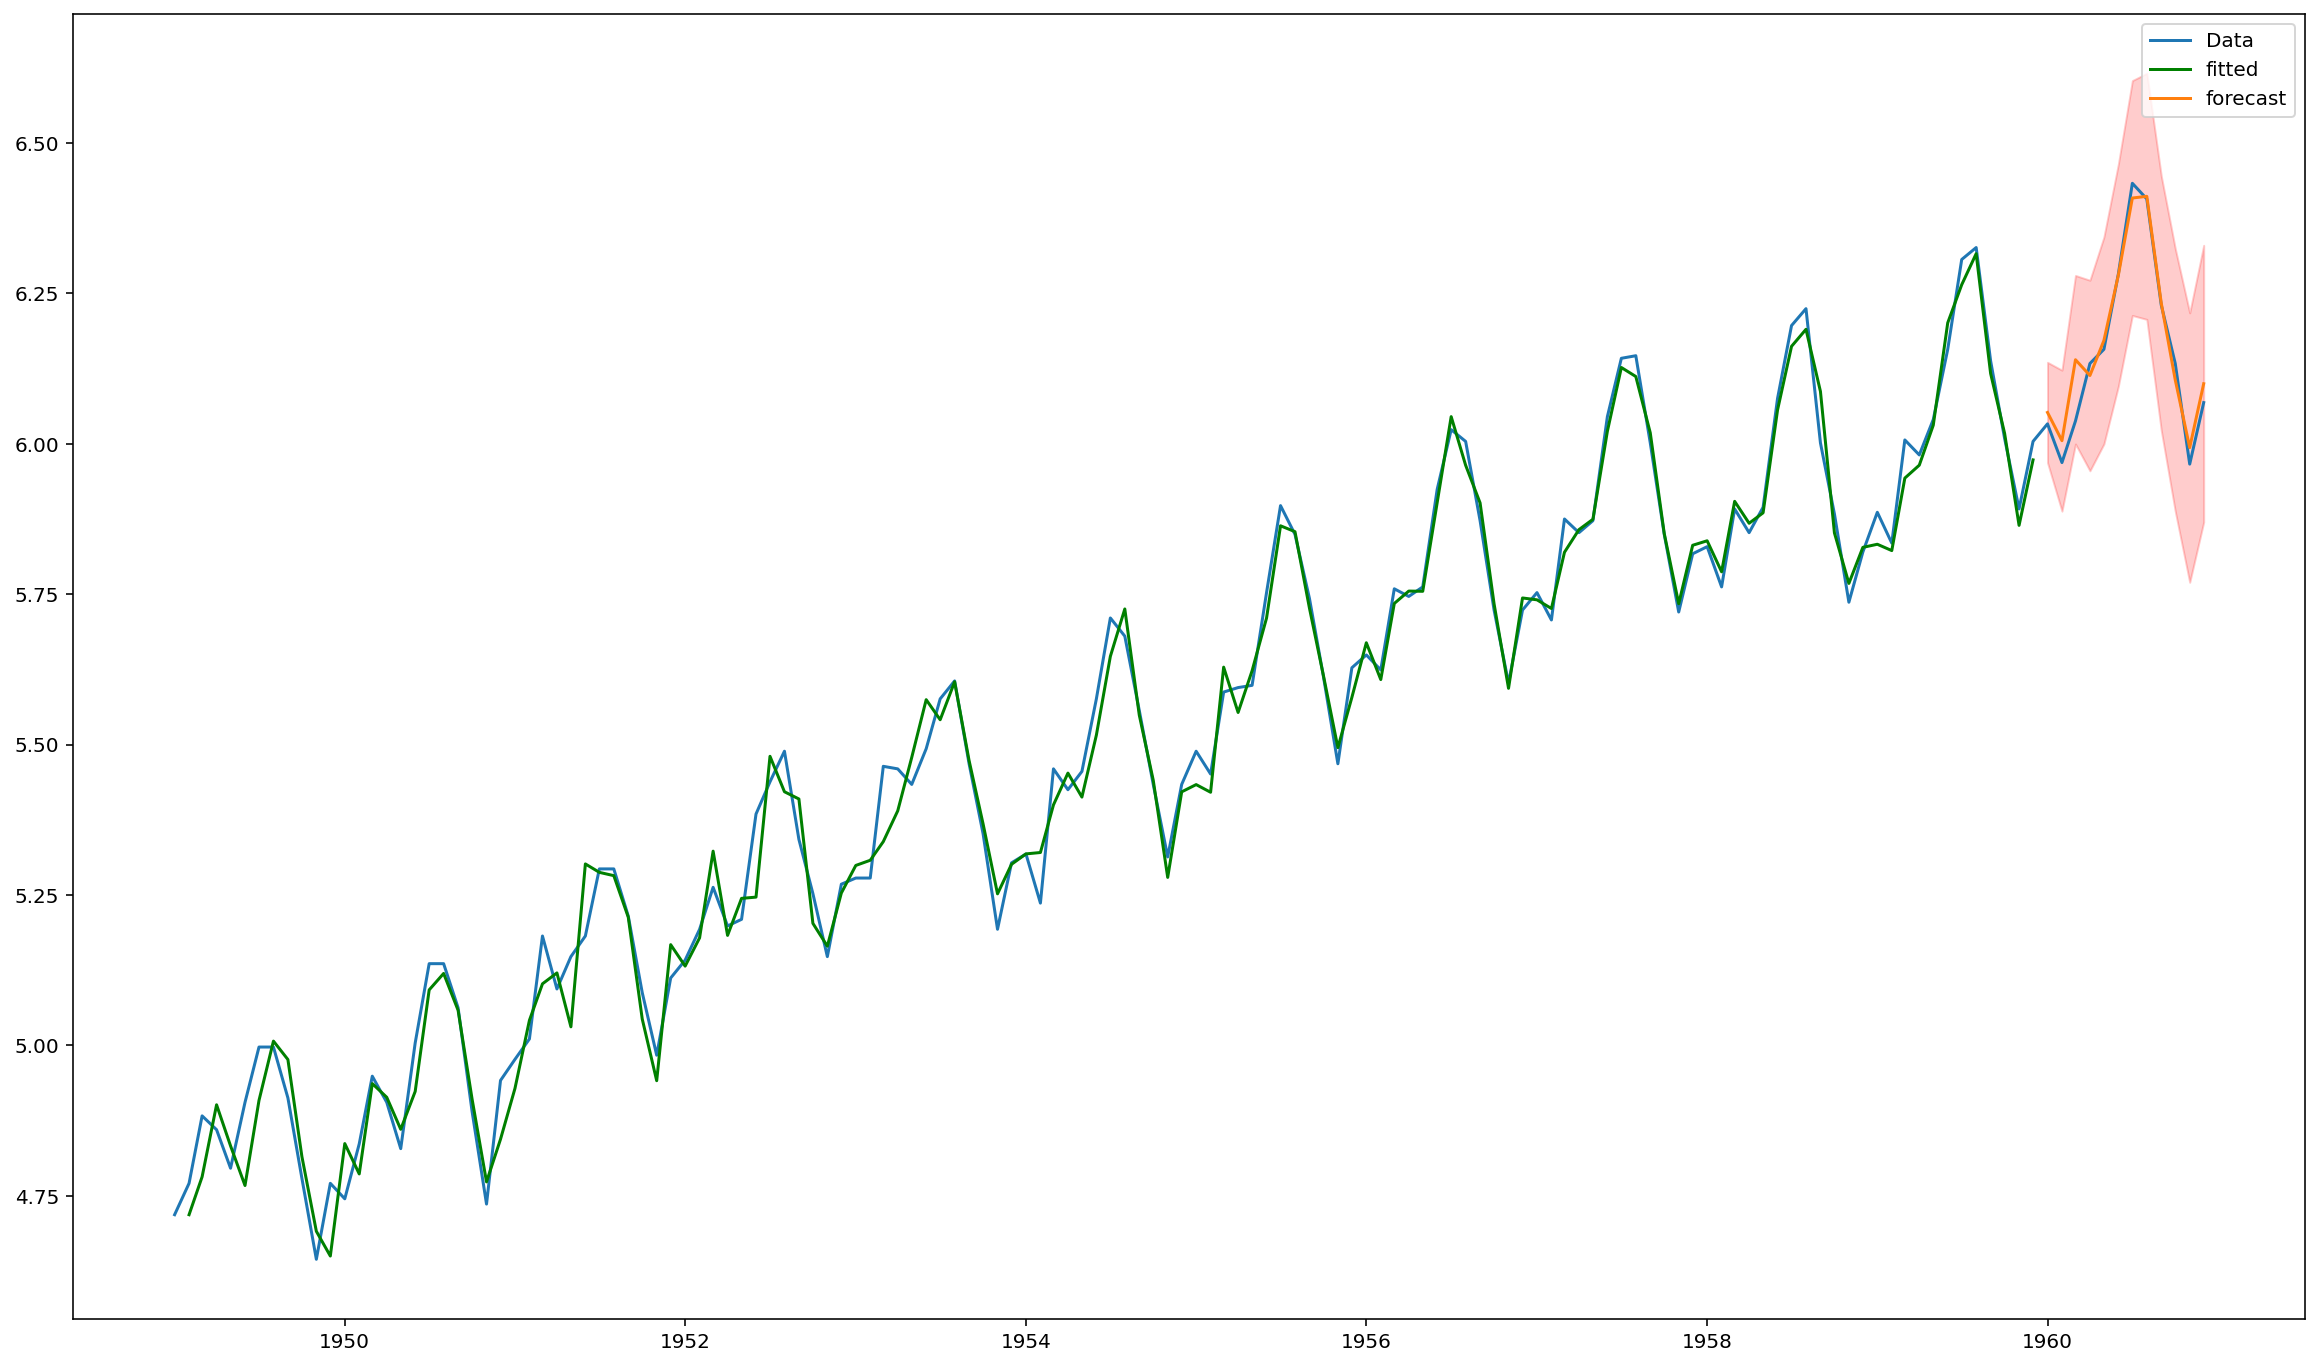

In [109]:
arima = ARIMA(train['Log_Passengers'], order=(12, 1, 0))
arima_result_1210_log = arima.fit()
plot_fit_and_forecast_int(arima_result_1210_log, 1, 'Log_Passengers')

- Путем проб и ошибок приходим к периоду 12, в целом цилк годовой, это логично.
- Пробоуем обычные значения подавать и логарифмированные.
- Обе модели с d=1. Т.е. для модели на логарифмических данных внутри ARIMA полдучается что используется Log_Return

### Что бы понять какая модель лучше, посчитаем метрику RMSE
можно было использовать и стандартные функции, но тут вот все инкапсулировали

ведь для лог значений нужно будет делать обратное преобразования для корректного сравнения

In [110]:
def rmse(arima_result, is_log):
    forecast = arima_result.forecast(N_test)
    
    if is_log:
        forecast = np.exp(forecast)
    
    y_true = test['Passengers']
    y_pred = forecast
    
    return  np.sqrt(np.mean((y_true - y_pred)**2))

In [111]:
print(f'ARIMA 8,1,1 RMSE: {rmse(arima_result_811, False):.2f}')
print(f'ARIMA 8,1,1 Log RMSE: {rmse(arima_result_811_log, False):.2f}')
print(f'ARIMA 12,1,0 RMSE: {rmse(arima_result_1210, False):.2f}')
print(f'ARIMA 12,1,0 Log RMSE: {rmse(arima_result_1210_log, True):.2f}')

ARIMA 8,1,1 RMSE: 59.06
ARIMA 8,1,1 Log RMSE: 475.93
ARIMA 12,1,0 RMSE: 17.49
ARIMA 12,1,0 Log RMSE: 16.13


Модель с логарифмическим признаком показывает чуть меньшую ошибку на тестовой выборке

c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Log RMSE: 15.13


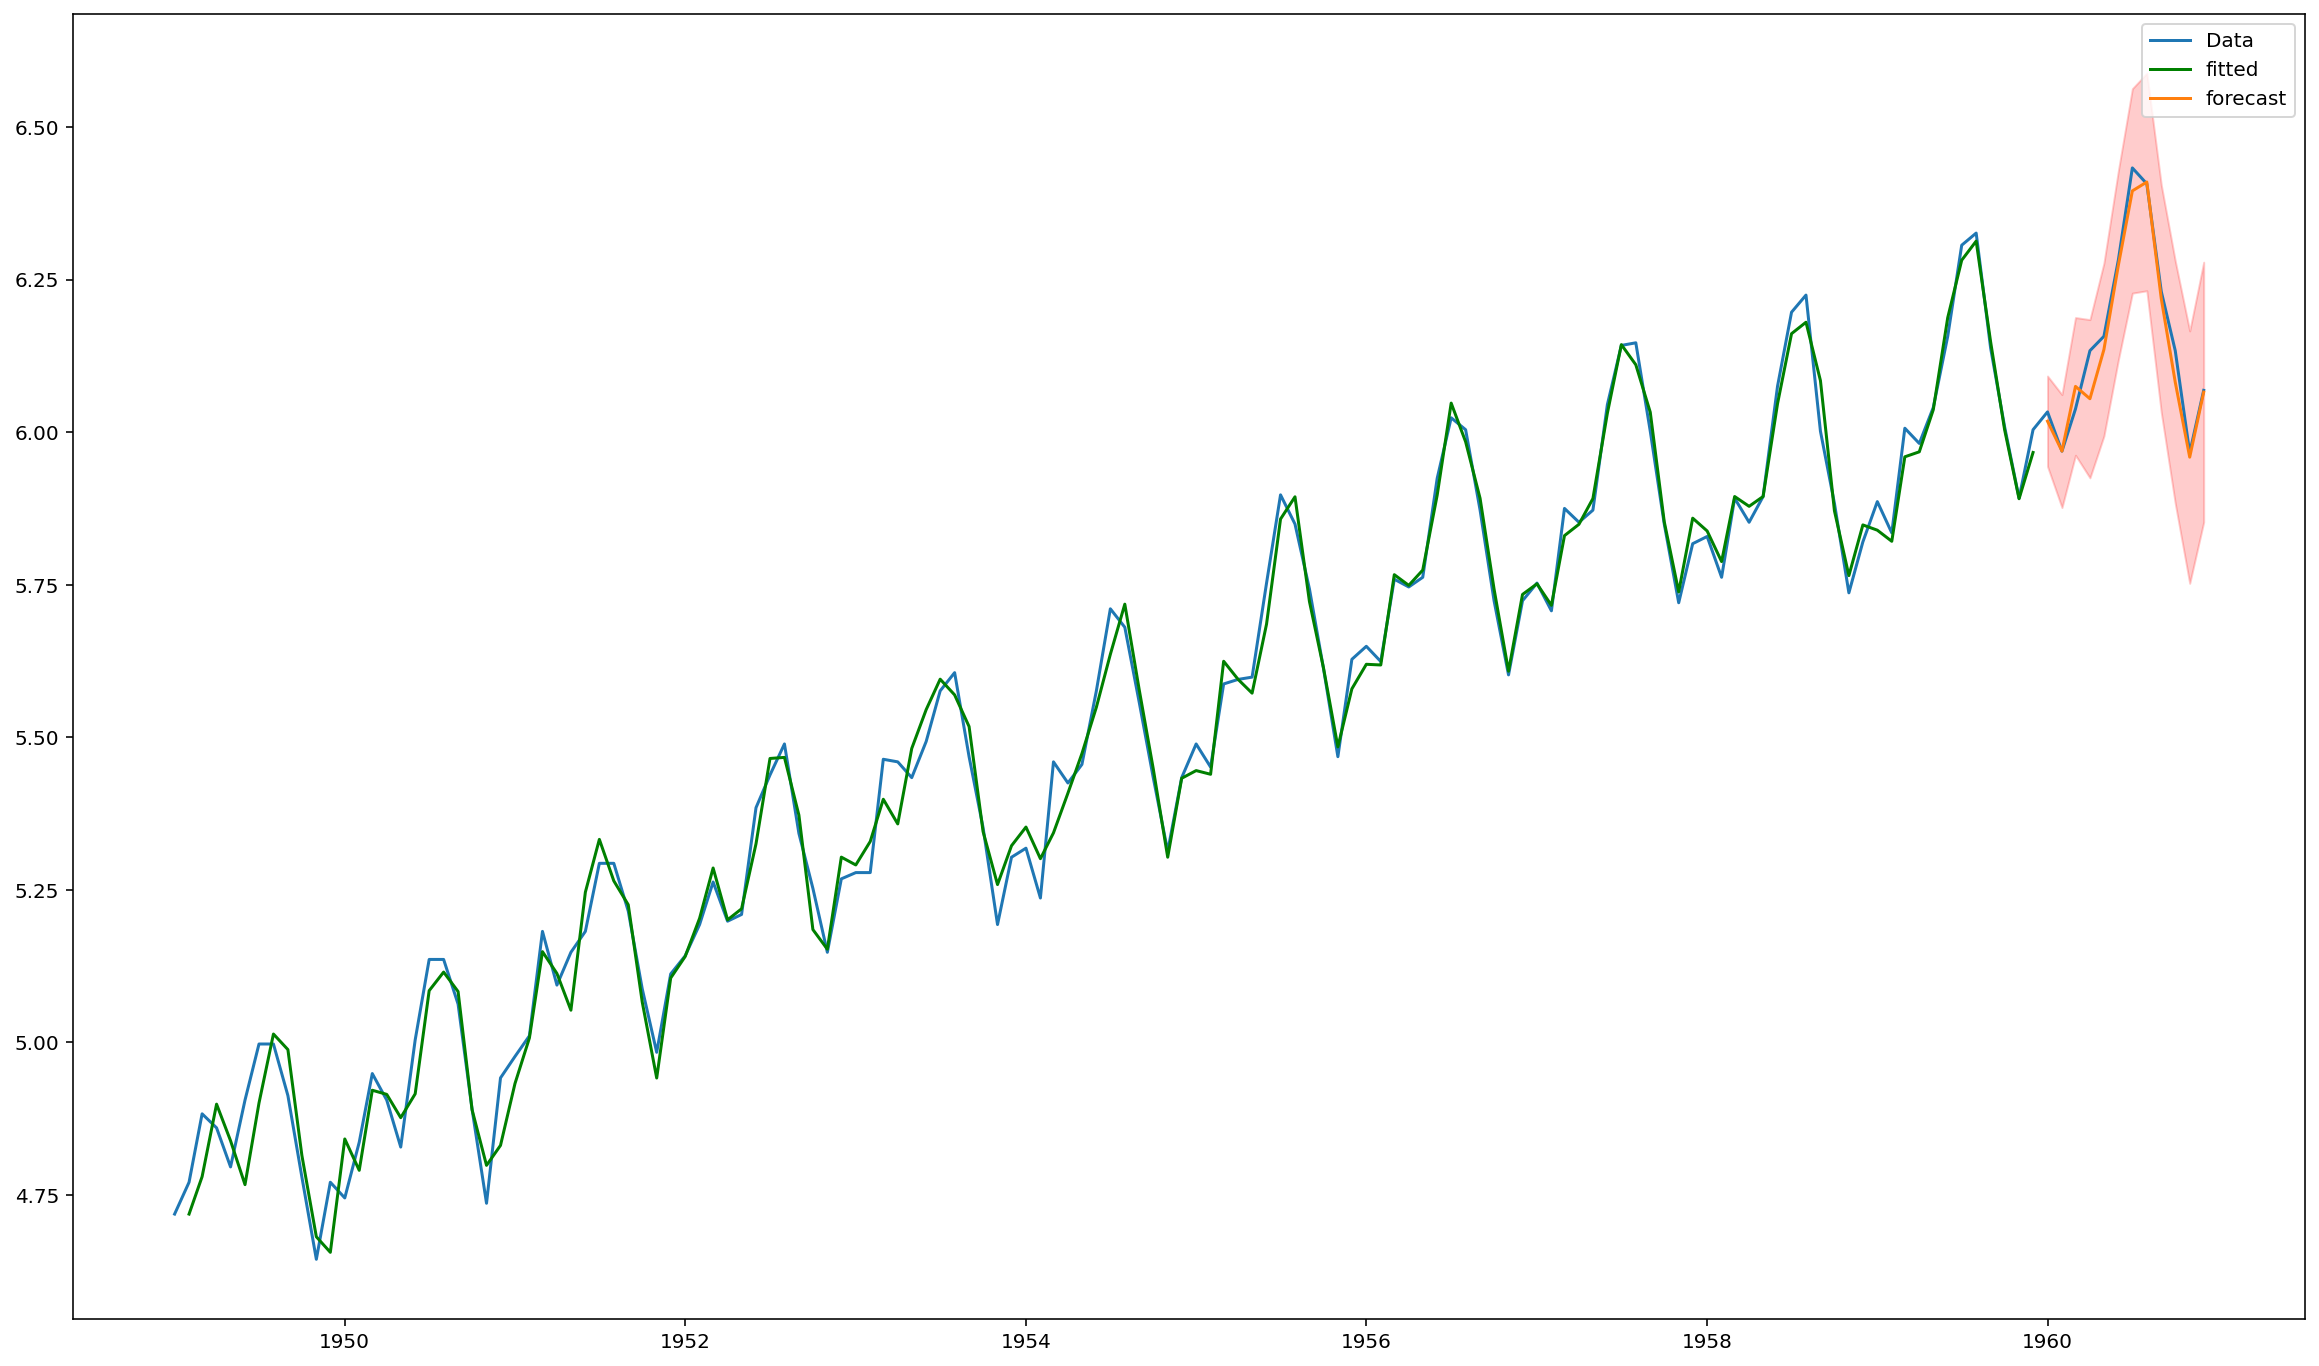

In [118]:
p = 24
d = 1
q = 0

arima = ARIMA(train['Log_Passengers'], order=(p, d, q))
arima_result = arima.fit()
plot_fit_and_forecast_int(arima_result, d, 'Log_Passengers')
print(f'ARIMA Log RMSE: {rmse(arima_result, True):.2f}')

 При p=24 т.е. на двухлетнем окне для авторегрессии ошибка получилась даже чуть меньше.